In [ ]:
# Import required libraries and setup paths for grain boundary velocity analysis
import os
current_path = os.getcwd()  # Get current working directory
import numpy as np
from numpy import seterr
seterr(all='raise')  # Set numpy to raise exceptions on all floating point errors
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar for loops
import sys

# Add necessary paths for importing custom modules
sys.path.append(current_path)  # Current directory
sys.path.append(current_path+'/../../')  # Parent directory for main modules
import myInput  # Custom input handling module
import PACKAGE_MP_Linear as linear2d  # 2D linear multi-physics package
import post_processing  # Post-processing utilities
sys.path.append(current_path+'/../calculate_tangent/')  # Path for tangent calculation utilities

<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

## 2D case

In [ ]:
if __name__ == '__main__':
    # =============================================================================
    # DATA LOADING AND SETUP
    # =============================================================================
    
    # Define file paths for data storage and retrieval
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"  # Main data folder
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"  # SPPARKS simulation results
    
    # Case configuration - this is an isotropic case with 20k grains
    case_name = "MI_20k_iso"
    
    # Define file names for microstructure and energy data
    # These files contain the simulation results from SPPARKS
    npy_file_name_aniso = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"  # Microstructure data
    npy_file_name_aniso_energy = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66_energy.npy"  # Energy data
    
    # Load microstructure data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)  # Load microstructure evolution
    npy_file_aniso = npy_file_aniso.astype(int)  # Convert to integer grain IDs
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    
    # Load energy data corresponding to the microstructure
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy)  # Load energy evolution
    print(f"The {case_name} data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    
    # Extract dimensions: time steps, spatial dimensions
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The MI_20k_iso data size is: (201, 2400, 2400, 1)
READING DATA DONE
The MI_20k_iso data size is: (201, 2400, 2400, 1)
READING ENERGY DATA DONE


In [ ]:
    # =============================================================================
    # GRAIN BOUNDARY CURVATURE CALCULATION
    # =============================================================================
    
    # Initialize parameters for GB analysis
    step_num = 121  # Number of time steps to analyze
    grain_nums = 20000  # Total number of grains in the system
    GB_infomation_dict_list = []  # List to store GB information for each time step
    curvature_matrix_list = []  # List to store curvature matrices
    
    # Process each time step to extract GB information and calculate curvature
    for time_step in tqdm(range(step_num)):
        # Define file names for cached data to avoid recomputation
        data_file_name = f"GB_velocity_data/2D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/2D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        
        # Try to load pre-computed data if available
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name, allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            # If pre-computed data doesn't exist, calculate from scratch
            current_microstructure = npy_file_aniso[time_step]
            
            # Calculate signed curvature using the linear solver
            if os.path.exists(data_file_folder + data_curvature_file_name):
                # Load pre-computed curvature matrix
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix)
            else:
                # Calculate curvature using the linear multi-physics solver
                cores = 128  # Number of CPU cores for parallel processing
                loop_times = 5  # Number of iterations for convergence
                R = np.zeros((size_x, size_y, 3))  # Initialize reference array
                
                # Create smoothing class instance for curvature calculation
                smoothing_class = linear2d.linear_class(
                    size_x, size_y, grain_nums, cores, loop_times,
                    current_microstructure[:, :, 0], R,
                    verification_system=False,
                    curvature_sign=True  # Calculate signed curvature
                )
                smoothing_class.linear_main("curvature")  # Run curvature calculation
                C_ln = smoothing_class.get_C()  # Get curvature results
                curvature_matrix = C_ln[1, :]  # Extract curvature matrix
                curvature_matrix_list.append(curvature_matrix)
                # save curvature information
                # np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # =============================================================================
            # TRIPLE JUNCTION (TJ) AND QUADRUPLE JUNCTION (QJ) DETECTION
            # =============================================================================
            
            # Identify triple and quadruple junctions to exclude them from GB analysis
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i, j, k = index
                # Get periodic boundary conditions for neighbors
                ip, im, jp, jm = myInput.periodic_bc(size_x, size_y, i, j)
                
                # Check if current voxel is at a grain boundary
                if (((current_microstructure[ip, j, k] - current_microstructure[i, j, k]) != 0) or 
                    ((current_microstructure[im, j, k] - current_microstructure[i, j, k]) != 0) or
                    ((current_microstructure[i, jp, k] - current_microstructure[i, j, k]) != 0) or 
                    ((current_microstructure[i, jm, k] - current_microstructure[i, j, k]) != 0)):
                    
                    central_site = int(current_microstructure[i, j, k])
                    
                    # Get all neighboring grain IDs
                    neighboring_sites_list = np.array([
                        current_microstructure[ip, j, k], current_microstructure[i, jp, k],
                        current_microstructure[im, j, k], current_microstructure[i, jm, k]
                    ]).astype(int)
                    
                    # Find unique neighboring grain IDs
                    neighboring_sites_set = set(neighboring_sites_list)
                    if central_site in neighboring_sites_set: 
                        neighboring_sites_set.remove(central_site)  # Remove central grain ID
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    
                    # If more than 1 neighboring grain, this is a junction point
                    if len(neighboring_sites_list_unque) > 1:
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m])
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i, j, k])
                                TJ_infomation_dict[pair_id] = tmp
                            else:
                                TJ_infomation_dict[pair_id] = [[i, j, k]]
            print("Finish TJ extraction")
            
            # =============================================================================
            # GRAIN BOUNDARY CENTER CALCULATION
            # =============================================================================
            
            # Calculate the center position and properties of each grain boundary
            GB_infomation_dict = dict()
            TJ_distance_max = 6  # Maximum distance from TJ to exclude (in voxels)
            
            for index, result in np.ndenumerate(current_microstructure):
                i, j, k = index
                ip, im, jp, jm = myInput.periodic_bc(size_x, size_y, i, j)
                
                # Check if current voxel is at a grain boundary
                if (((current_microstructure[ip, j, k] - current_microstructure[i, j, k]) != 0) or 
                    ((current_microstructure[im, j, k] - current_microstructure[i, j, k]) != 0) or
                    ((current_microstructure[i, jp, k] - current_microstructure[i, j, k]) != 0) or 
                    ((current_microstructure[i, jm, k] - current_microstructure[i, j, k]) != 0)):
                    
                    central_site = int(current_microstructure[i, j, k])
                    neighboring_sites_list = np.array([
                        current_microstructure[ip, j, k], current_microstructure[i, jp, k],
                        current_microstructure[im, j, k], current_microstructure[i, jm, k]
                    ]).astype(int)
                    
                    neighboring_sites_set = set(neighboring_sites_list)
                    if central_site in neighboring_sites_set: 
                        neighboring_sites_set.remove(central_site)
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    
                    # Skip junction points (more than 2 grains meeting)
                    if len(neighboring_sites_list_unque) > 1: 
                        continue
                    
                    # Check distance from triple junctions to exclude nearby voxels
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0])
                    if central_site < neighboring_sites_list_unque[0]: 
                        pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: 
                        pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    
                    # Initialize or update GB information
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1  # Increment GB area count
                    else:
                        # [GB_count, sum_i, sum_j, sum_k, sum_curvature, area, grain_id1, grain_id2]
                        GB_infomation = np.array([0, 0, 0, 0, 0.0, 1, pair_id_pair[0], pair_id_pair[1]])
                        GB_infomation_dict[pair_id] = GB_infomation
                    
                    # Check if this voxel is too close to a triple junction
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index - np.array(TJ_site))
                            if TJ_distance < TJ_distance_max:
                                break_point = 1
                                break
                    if break_point == 1: 
                        continue
                    
                    # Accumulate GB properties (position and curvature)
                    GB_infomation_dict[pair_id][0] += 1  # Increment valid voxel count
                    if central_site == pair_id_pair[0]:
                        # Add position and curvature with correct sign
                        GB_infomation_dict[pair_id][1:5] += np.array([i, j, k, curvature_matrix[i, j]])
                    else:
                        # Flip curvature sign for opposite grain orientation
                        GB_infomation_dict[pair_id][1:5] += np.array([i, j, k, -curvature_matrix[i, j]])
            
            # =============================================================================
            # POST-PROCESSING: REMOVE SMALL GBs AND CALCULATE AVERAGES
            # =============================================================================
            
            # Remove grain boundaries with no valid voxels after TJ filtering
            small_GB_list = []
            for key in GB_infomation_dict:
                if GB_infomation_dict[key][0] == 0:
                    small_GB_list.append(key)
            for s_index in range(len(small_GB_list)): 
                GB_infomation_dict.pop(small_GB_list[s_index])
            
            # Calculate average position and curvature for each GB
            for key in GB_infomation_dict:
                GB_infomation_dict[key][1:5] = GB_infomation_dict[key][1:5] / GB_infomation_dict[key][0]
            
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            
            # Save computed information for future use
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)

100%|██████████| 121/121 [00:00<00:00, 128.11it/s]


In [ ]:
    # =============================================================================
    # GRAIN BOUNDARY ENERGY CALCULATION
    # =============================================================================
    
    # Similar to curvature calculation, but focused on extracting GB energy information
    step_num = 121
    grain_nums = 20000
    GBenergy_information_dict_list = []  # Store GB energy information for each time step
    
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/2D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        
        # Try to load pre-computed energy data
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy, allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            # Calculate energy information from scratch
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]  # Load corresponding energy data

            # Re-extract triple junction information for energy calculation
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i, j, k = index
                ip, im, jp, jm = myInput.periodic_bc(size_x, size_y, i, j)
                
                if (((current_microstructure[ip, j, k] - current_microstructure[i, j, k]) != 0) or 
                    ((current_microstructure[im, j, k] - current_microstructure[i, j, k]) != 0) or
                    ((current_microstructure[i, jp, k] - current_microstructure[i, j, k]) != 0) or 
                    ((current_microstructure[i, jm, k] - current_microstructure[i, j, k]) != 0)):
                    
                    central_site = int(current_microstructure[i, j, k])
                    neighboring_sites_list = np.array([
                        current_microstructure[ip, j, k], current_microstructure[i, jp, k],
                        current_microstructure[im, j, k], current_microstructure[i, jm, k]
                    ]).astype(int)
                    
                    neighboring_sites_set = set(neighboring_sites_list)
                    if central_site in neighboring_sites_set: 
                        neighboring_sites_set.remove(central_site)
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    
                    # Identify triple and quadruple junctions
                    if len(neighboring_sites_list_unque) > 1:
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m])
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i, j, k])
                                TJ_infomation_dict[pair_id] = tmp
                            else:
                                TJ_infomation_dict[pair_id] = [[i, j, k]]
            print("Finish TJ extraction")

            # Calculate GB energy information
            GBenergy_information_dict = dict()
            TJ_distance_max = 6  # Maximum distance from TJ to exclude (in voxels)
            
            for index, result in np.ndenumerate(current_microstructure):
                i, j, k = index
                ip, im, jp, jm = myInput.periodic_bc(size_x, size_y, i, j)
                
                if (((current_microstructure[ip, j, k] - current_microstructure[i, j, k]) != 0) or 
                    ((current_microstructure[im, j, k] - current_microstructure[i, j, k]) != 0) or
                    ((current_microstructure[i, jp, k] - current_microstructure[i, j, k]) != 0) or 
                    ((current_microstructure[i, jm, k] - current_microstructure[i, j, k]) != 0)):
                    
                    central_site = int(current_microstructure[i, j, k])
                    neighboring_sites_list = np.array([
                        current_microstructure[ip, j, k], current_microstructure[i, jp, k],
                        current_microstructure[im, j, k], current_microstructure[i, jm, k]
                    ]).astype(int)
                    
                    neighboring_sites_set = set(neighboring_sites_list)
                    if central_site in neighboring_sites_set: 
                        neighboring_sites_set.remove(central_site)
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    
                    # Count the number of different neighboring grains in extended neighborhood
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([
                        current_microstructure[ip, jp, k], current_microstructure[ip, j, k], 
                        current_microstructure[ip, jm, k], current_microstructure[i, jp, k], 
                        current_microstructure[i, jm, k], current_microstructure[im, jp, k], 
                        current_microstructure[im, j, k], current_microstructure[im, jm, k]
                    ]).astype(int)
                    
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: 
                            num_other_sites += 1  # Count sites different from central grain
                    
                    # Skip junction points
                    if len(neighboring_sites_list_unque) > 1: 
                        continue
                    
                    # Check distance from triple junctions
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0])
                    if central_site < neighboring_sites_list_unque[0]: 
                        pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: 
                        pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    
                    # Initialize or update GB energy information
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1  # Increment area count
                    else:
                        # [GB_count, sum_i, sum_j, sum_k, sum_energy, area, grain_id1, grain_id2]
                        GB_infomation = np.array([0, 0, 0, 0, 0.0, 1, pair_id_pair[0], pair_id_pair[1]])
                        GBenergy_information_dict[pair_id] = GB_infomation
                    
                    # Check distance from triple junctions
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index - np.array(TJ_site))
                            if TJ_distance < TJ_distance_max:
                                break_point = 1
                                break
                    if break_point == 1: 
                        continue
                    
                    # Accumulate GB energy and position information
                    GBenergy_information_dict[pair_id][0] += 1  # Increment valid voxel count
                    # Add position and normalized energy (energy per neighboring grain)
                    GBenergy_information_dict[pair_id][1:5] += np.array([i, j, k, current_energy[i, j, k] / num_other_sites])

            # Remove small GBs and calculate averages
            small_GB_list = []
            for key in GBenergy_information_dict:
                if GBenergy_information_dict[key][0] == 0:
                    small_GB_list.append(key)
            for s_index in range(len(small_GB_list)): 
                GBenergy_information_dict.pop(small_GB_list[s_index])
            
            # Calculate average position and energy for each GB
            for key in GBenergy_information_dict:
                GBenergy_information_dict[key][1:5] = GBenergy_information_dict[key][1:5] / GBenergy_information_dict[key][0]
            
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            
            # Save energy information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 121/121 [00:00<00:00, 132.49it/s]


In [ ]:
    # =============================================================================
    # VELOCITY CALCULATION FUNCTIONS AND MAIN PROCESSING
    # =============================================================================
    
    from numba import njit, prange
    import multiprocessing as mp
    
    # Optimized function to calculate volume change (dV) between time steps
    @njit(parallel=True)
    def compute_dV(npy_file_aniso_current, npy_file_aniso_next, pair_id_pair):
        """
        Calculate net volume change for a grain boundary between two time steps.
        
        Parameters:
        - npy_file_aniso_current: microstructure at current time step
        - npy_file_aniso_next: microstructure at next time step  
        - pair_id_pair: [grain_id1, grain_id2] for the grain boundary
        
        Returns:
        - Net volume change (positive = grain1 growing into grain2)
        """
        # Count voxels where grain1 grows into grain2
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        # Count voxels where grain2 grows into grain1
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2)
    
    # Extended version that returns individual directional growth components
    @njit(parallel=True)
    def compute_dV_split(npy_file_aniso_current, npy_file_aniso_next, pair_id_pair):
        """
        Calculate volume change with separated directional components.
        
        Returns:
        - Net volume change, growth_direction1, growth_direction2
        """
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)
    
    def compute_necessary_info(key, time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        """
        Compute GB velocity, curvature, energy, and anti-curvature behavior for one GB.
        
        Parameters:
        - key: GB identifier
        - time_interval: time between steps
        - GB_infomation_dict_list_one_step_one_key: GB curvature info
        - GBenergy_information_dict_list_one_step_one_key: GB energy info
        - npy_file_aniso_current/next: microstructures at current and next time steps
        
        Returns:
        - Dictionary with velocity, curvature, energy, and anti-curvature flag
        """
        # Calculate volume change and convert to velocity
        dV = compute_dV(npy_file_aniso_current, npy_file_aniso_next, GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV / time_interval / (GB_infomation_dict_list_one_step_one_key[5] / 2)  # Normalize by area and time
        
        # Extract curvature and energy values
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < 0  # Anti-curvature: opposite signs
        }
        
        return result
    
    def compute_necessary_info_split(key, time_interval,
                                   GB_infomation_dict_list_one_step_one_key,
                                   GBenergy_information_dict_list_one_step_one_key,
                                   npy_file_aniso_current,
                                   npy_file_aniso_next):
        """
        Extended version that includes directional growth components.
        """
        # Calculate volume change with directional split
        dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current, npy_file_aniso_next, 
                                                            GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV / time_interval / (GB_infomation_dict_list_one_step_one_key[5] / 2)
        
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "dV_direction1": dV_direction1,  # Growth of grain1 into grain2
            "dV_direction2": dV_direction2,  # Growth of grain2 into grain1
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < 0
        }
        
        return result
    
    # =============================================================================
    # MAIN VELOCITY ANALYSIS LOOP
    # =============================================================================
    
    # Analysis parameters
    time_interval = 30  # Time interval between steps
    curvature_limit = 0.0182  # Minimum curvature threshold for analysis
    area_limit = 100  # Minimum GB area threshold
    
    # Initialize storage arrays for all GB data
    GB_list_velocity_list = []  # Store velocities for each time step
    GB_list_curvature_list = []  # Store curvatures for each time step
    GB_list_GBenergy_list = []  # Store energies for each time step
    GB_list_area_list = []  # Store areas for each time step
    GB_list_dV_direction1 = []  # Store directional growth data
    GB_list_dV_direction2 = []
    
    # Track anti-curvature GBs specifically
    GB_id_focus = dict()  # Count of anti-curvature occurrences per GB
    GB_id_focus_detail = dict()  # Detailed time step records per GB
    GB_filter_kernel = [set(), set(), set(), set(), set()]  # 5-step sliding window filter
    dV_dict = []  # Store all computed results
    
    # Process each time step to calculate velocities and identify anti-curvature behavior
    for time_step in range(step_num):
        if time_step + 1 >= step_num: 
            continue  # Skip last step (no next step for velocity calculation)
        
        # Initialize temporary storage for current time step
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_area_list_tmp = []
        GB_list_dV_direction1_tmp = []
        GB_list_dV_direction2_tmp = []
        key_set = set()

        # =============================================================================
        # FILTERING: Remove unsuitable GBs for analysis
        # =============================================================================
        
        print(f"key num start with {len(GB_infomation_dict_list[time_step])}")
        tmp_GB_infomation_dict_for_mp = {}
        tmp_GBenergy_information_dict_for_mp = {}
        
        # Filter GBs based on area, persistence, and curvature criteria
        for key in GB_infomation_dict_list[time_step]:
            if (GB_infomation_dict_list[time_step][key][5] < area_limit or  # Too small area
                GB_infomation_dict_list[time_step + 1].get(key) is None or  # Disappears in next step
                abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit):  # Too low curvature
                continue
            tmp_GB_infomation_dict_for_mp[key] = GB_infomation_dict_list[time_step][key]
            tmp_GBenergy_information_dict_for_mp[key] = GBenergy_information_dict_list[time_step][key]
        
        print(f"key num end with {len(tmp_GB_infomation_dict_for_mp)}")
        
        # =============================================================================
        # VELOCITY CALCULATION WITH CACHING
        # =============================================================================
        
        # Try to load pre-computed velocity data
        dV_dict_file_name = f"GB_velocity_data/2D_dV_split_data_{case_name}_areaLimit{area_limit}_step{time_step}.npz"
        if os.path.exists(data_file_folder + dV_dict_file_name):
            npz_file = np.load(data_file_folder + dV_dict_file_name, allow_pickle=True)
            dV_dict_tmp = npz_file["dV_dict_tmp"]
            dV_dict_tmp = dV_dict_tmp.item()
        else:
            dV_dict_tmp = {}
        
        # Calculate or retrieve velocity data for each GB
        for key in tqdm(tmp_GB_infomation_dict_for_mp):
            if key in dV_dict_tmp:
                result = dV_dict_tmp[key]  # Use cached result
            else:
                # Compute new result
                result = compute_necessary_info_split(
                    key, time_interval,
                    tmp_GB_infomation_dict_for_mp[key],
                    tmp_GBenergy_information_dict_for_mp[key],
                    npy_file_aniso[time_step],
                    npy_file_aniso[time_step + 1]
                )
                dV_dict_tmp[key] = result
            
            # Store results for all GBs
            GB_list_velocity_list_tmp.append(result["velocity"])
            GB_list_curvature_list_tmp.append(result["current_curvature_value"])
            GB_list_GBenergy_list_tmp.append(result["current_eng"])
            GB_list_dV_direction1_tmp.append(result["dV_direction1"])
            GB_list_dV_direction2_tmp.append(result["dV_direction2"])
            
            # Calculate and store GB area
            current_GB_area = 0.5 * tmp_GB_infomation_dict_for_mp[key][0]
            GB_list_area_list_tmp.append(current_GB_area)

            # =============================================================================
            # ANTI-CURVATURE TRACKING
            # =============================================================================
            
            # Track GBs showing anti-curvature behavior
            if result["is_anti_curvature"]:
                key_set.add(key)
                if time_step >= step_num - 3: 
                    continue  # Skip near end of simulation
                if key in GB_id_focus:
                    GB_id_focus[key] += 1  # Increment anti-curvature count
                    GB_id_focus_detail[key].append(time_step)
                else:
                    GB_id_focus[key] = 1  # First anti-curvature occurrence
                    GB_id_focus_detail[key] = [time_step]
        
        # Save computed data if not already cached
        if not os.path.exists(data_file_folder + dV_dict_file_name):
            np.savez(data_file_folder + dV_dict_file_name, dV_dict_tmp=dV_dict_tmp)
            # pass
        
        # Store results for current time step
        dV_dict.append(dV_dict_tmp)
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        GB_list_area_list.append(GB_list_area_list_tmp)
        GB_list_dV_direction1.append(GB_list_dV_direction1_tmp)
        GB_list_dV_direction2.append(GB_list_dV_direction2_tmp)

        # =============================================================================
        # SLIDING WINDOW FILTER FOR ANTI-CURVATURE BEHAVIOR
        # =============================================================================
        
        # Update sliding window filter (5-step window)
        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        
        # Apply "00100" filter: anti-curvature at step 2, normal at steps 0,1,3,4
        # This filters out random/transient anti-curvature behavior
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0] | GB_filter_kernel[1] | 
                                             GB_filter_kernel[3] | GB_filter_kernel[4])
        
        # Remove filtered GBs from tracking
        for key in filtered_set:
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step - 2)
        
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")

    # =============================================================================
    # FINAL FILTERING: Remove GBs with insufficient anti-curvature behavior
    # =============================================================================
    
    # Remove GBs that don't show consistent anti-curvature behavior
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <= 0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)

key num start with 22827
key num end with 0


0it [00:00, ?it/s]


finish 0 with num of GBs 0, and collected num of GBs 0
key num start with 17928
key num end with 0


0it [00:00, ?it/s]


finish 1 with num of GBs 0, and collected num of GBs 0
key num start with 15315
key num end with 0


0it [00:00, ?it/s]


finish 2 with num of GBs 0, and collected num of GBs 0
key num start with 12849
key num end with 0


0it [00:00, ?it/s]


finish 3 with num of GBs 0, and collected num of GBs 0
key num start with 10792
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 37282.70it/s]


finish 4 with num of GBs 2, and collected num of GBs 0
key num start with 9309
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 77672.30it/s]


finish 5 with num of GBs 5, and collected num of GBs 1
key num start with 8283
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 96420.78it/s]


finish 6 with num of GBs 6, and collected num of GBs 3
key num start with 7359
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 61455.00it/s]


finish 7 with num of GBs 4, and collected num of GBs 4
key num start with 6606
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 92862.82it/s]


finish 8 with num of GBs 6, and collected num of GBs 5
key num start with 5992
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 129854.61it/s]


finish 9 with num of GBs 10, and collected num of GBs 6
key num start with 5577
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 129055.51it/s]


finish 10 with num of GBs 8, and collected num of GBs 6
key num start with 5143
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 147168.56it/s]


finish 11 with num of GBs 10, and collected num of GBs 6
key num start with 4697
key num end with 17


100%|██████████| 17/17 [00:00<00:00, 180972.51it/s]


finish 12 with num of GBs 17, and collected num of GBs 7
key num start with 4453
key num end with 16


100%|██████████| 16/16 [00:00<00:00, 168615.24it/s]


finish 13 with num of GBs 16, and collected num of GBs 10
key num start with 4192
key num end with 14


100%|██████████| 14/14 [00:00<00:00, 181235.36it/s]


finish 14 with num of GBs 14, and collected num of GBs 10
key num start with 3993
key num end with 13


100%|██████████| 13/13 [00:00<00:00, 193354.44it/s]


finish 15 with num of GBs 13, and collected num of GBs 10
key num start with 3761
key num end with 17


100%|██████████| 17/17 [00:00<00:00, 193758.61it/s]


finish 16 with num of GBs 17, and collected num of GBs 10
key num start with 3562
key num end with 14


100%|██████████| 14/14 [00:00<00:00, 196388.82it/s]


finish 17 with num of GBs 14, and collected num of GBs 11
key num start with 3378
key num end with 13


100%|██████████| 13/13 [00:00<00:00, 192671.21it/s]


finish 18 with num of GBs 13, and collected num of GBs 11
key num start with 3241
key num end with 16


100%|██████████| 16/16 [00:00<00:00, 209715.20it/s]


finish 19 with num of GBs 16, and collected num of GBs 11
key num start with 3116
key num end with 15


100%|██████████| 15/15 [00:00<00:00, 198468.64it/s]


finish 20 with num of GBs 15, and collected num of GBs 13
key num start with 2991
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 132104.06it/s]


finish 21 with num of GBs 8, and collected num of GBs 13
key num start with 2871
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 123361.88it/s]


finish 22 with num of GBs 7, and collected num of GBs 13
key num start with 2730
key num end with 14


100%|██████████| 14/14 [00:00<00:00, 192525.43it/s]


finish 23 with num of GBs 14, and collected num of GBs 13
key num start with 2607
key num end with 13


100%|██████████| 13/13 [00:00<00:00, 154464.45it/s]


finish 24 with num of GBs 13, and collected num of GBs 14
key num start with 2545
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 147168.56it/s]


finish 25 with num of GBs 10, and collected num of GBs 14
key num start with 2460
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 82891.38it/s]


finish 26 with num of GBs 5, and collected num of GBs 15
key num start with 2370
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 105120.40it/s]


finish 27 with num of GBs 10, and collected num of GBs 17
key num start with 2270
key num end with 12


100%|██████████| 12/12 [00:00<00:00, 153919.41it/s]


finish 28 with num of GBs 12, and collected num of GBs 19
key num start with 2186
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 101592.14it/s]


finish 29 with num of GBs 7, and collected num of GBs 19
key num start with 2136
key num end with 13


100%|██████████| 13/13 [00:00<00:00, 148572.08it/s]


finish 30 with num of GBs 13, and collected num of GBs 21
key num start with 2068
key num end with 9


100%|██████████| 9/9 [00:00<00:00, 134337.14it/s]


finish 31 with num of GBs 9, and collected num of GBs 21
key num start with 2010
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 93727.46it/s]


finish 32 with num of GBs 8, and collected num of GBs 22
key num start with 1960
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 151269.98it/s]


finish 33 with num of GBs 11, and collected num of GBs 23
key num start with 1913
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 124275.67it/s]


finish 34 with num of GBs 8, and collected num of GBs 24
key num start with 1841
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 130055.94it/s]


finish 35 with num of GBs 8, and collected num of GBs 24
key num start with 1799
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 81284.96it/s]


finish 36 with num of GBs 5, and collected num of GBs 24
key num start with 1744
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 135300.13it/s]


finish 37 with num of GBs 10, and collected num of GBs 25
key num start with 1705
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 129055.51it/s]


finish 38 with num of GBs 8, and collected num of GBs 26
key num start with 1665
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 40920.04it/s]


finish 39 with num of GBs 2, and collected num of GBs 26
key num start with 1623
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 37617.08it/s]


finish 40 with num of GBs 2, and collected num of GBs 27
key num start with 1598
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 69905.07it/s]

finish 41 with num of GBs 4, and collected num of GBs 28
key num start with 1559
key num end with 3



100%|██████████| 3/3 [00:00<00:00, 49539.02it/s]


finish 42 with num of GBs 3, and collected num of GBs 29
key num start with 1519
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 58798.65it/s]


finish 43 with num of GBs 3, and collected num of GBs 29
key num start with 1494
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 93902.33it/s]


finish 44 with num of GBs 6, and collected num of GBs 29
key num start with 1472
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 51150.05it/s]


finish 45 with num of GBs 3, and collected num of GBs 29
key num start with 1408
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 80659.69it/s]


finish 46 with num of GBs 5, and collected num of GBs 29
key num start with 1388
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 90200.09it/s]


finish 47 with num of GBs 6, and collected num of GBs 31
key num start with 1356
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 36314.32it/s]


finish 48 with num of GBs 2, and collected num of GBs 31
key num start with 1327
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 105738.76it/s]


finish 49 with num of GBs 6, and collected num of GBs 31
key num start with 1313
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]


finish 50 with num of GBs 1, and collected num of GBs 31
key num start with 1286
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 154823.30it/s]


finish 51 with num of GBs 11, and collected num of GBs 31
key num start with 1265
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 37117.73it/s]


finish 52 with num of GBs 2, and collected num of GBs 31
key num start with 1241
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 107546.26it/s]


finish 53 with num of GBs 7, and collected num of GBs 31
key num start with 1224
key num end with 10


100%|██████████| 10/10 [00:00<00:00, 153637.51it/s]


finish 54 with num of GBs 10, and collected num of GBs 31
key num start with 1203
key num end with 7


100%|██████████| 7/7 [00:00<00:00, 112923.57it/s]


finish 55 with num of GBs 7, and collected num of GBs 31
key num start with 1175
key num end with 11


100%|██████████| 11/11 [00:00<00:00, 152772.66it/s]


finish 56 with num of GBs 11, and collected num of GBs 31
key num start with 1148
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 74898.29it/s]

finish 57 with num of GBs 5, and collected num of GBs 32
key num start with 1136
key num end with 3



100%|██████████| 3/3 [00:00<00:00, 48770.98it/s]


finish 58 with num of GBs 3, and collected num of GBs 32
key num start with 1126
key num end with 8


100%|██████████| 8/8 [00:00<00:00, 129553.79it/s]


finish 59 with num of GBs 8, and collected num of GBs 32
key num start with 1098
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 81284.96it/s]

finish 60 with num of GBs 5, and collected num of GBs 33
key num start with 1082
key num end with 3



100%|██████████| 3/3 [00:00<00:00, 50533.78it/s]

finish 61 with num of GBs 3, and collected num of GBs 33
key num start with 1073
key num end with 4



100%|██████████| 4/4 [00:00<00:00, 116508.44it/s]


finish 62 with num of GBs 4, and collected num of GBs 33
key num start with 1053
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 62601.55it/s]


finish 63 with num of GBs 2, and collected num of GBs 33
key num start with 1029
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 155344.59it/s]


finish 64 with num of GBs 6, and collected num of GBs 33
key num start with 1014
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 164482.51it/s]


finish 65 with num of GBs 6, and collected num of GBs 33
key num start with 997
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 87992.39it/s]


finish 66 with num of GBs 3, and collected num of GBs 34
key num start with 980
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 93902.33it/s]


finish 67 with num of GBs 3, and collected num of GBs 34
key num start with 968
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 122461.43it/s]

finish 68 with num of GBs 4, and collected num of GBs 34
key num start with 953
key num end with 5



100%|██████████| 5/5 [00:00<00:00, 129453.83it/s]


finish 69 with num of GBs 5, and collected num of GBs 35
key num start with 930
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 121574.03it/s]


finish 70 with num of GBs 4, and collected num of GBs 35
key num start with 914
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 97541.95it/s]


finish 71 with num of GBs 3, and collected num of GBs 35
key num start with 893
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 36157.79it/s]

finish 72 with num of GBs 1, and collected num of GBs 35
key num start with 887
key num end with 5



100%|██████████| 5/5 [00:00<00:00, 144631.17it/s]


finish 73 with num of GBs 5, and collected num of GBs 35
key num start with 878
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 114912.44it/s]


finish 74 with num of GBs 4, and collected num of GBs 36
key num start with 870
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]


finish 75 with num of GBs 1, and collected num of GBs 36
key num start with 854
key num end with 0


0it [00:00, ?it/s]


finish 76 with num of GBs 0, and collected num of GBs 36
key num start with 832
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 66576.25it/s]


finish 77 with num of GBs 2, and collected num of GBs 36
key num start with 826
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 98304.00it/s]


finish 78 with num of GBs 3, and collected num of GBs 36
key num start with 819
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 68200.07it/s]


finish 79 with num of GBs 2, and collected num of GBs 36
key num start with 797
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]


finish 80 with num of GBs 1, and collected num of GBs 36
key num start with 797
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]


finish 81 with num of GBs 1, and collected num of GBs 36
key num start with 790
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 35544.95it/s]


finish 82 with num of GBs 1, and collected num of GBs 36
key num start with 790
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 95325.09it/s]


finish 83 with num of GBs 3, and collected num of GBs 36
key num start with 788
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]


finish 84 with num of GBs 1, and collected num of GBs 36
key num start with 778
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 97541.95it/s]


finish 85 with num of GBs 3, and collected num of GBs 36
key num start with 765
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]


finish 86 with num of GBs 1, and collected num of GBs 36
key num start with 749
key num end with 0


0it [00:00, ?it/s]


finish 87 with num of GBs 0, and collected num of GBs 36
key num start with 748
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 146653.99it/s]

finish 88 with num of GBs 5, and collected num of GBs 36
key num start with 737
key num end with 0



0it [00:00, ?it/s]


finish 89 with num of GBs 0, and collected num of GBs 36
key num start with 723
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]


finish 90 with num of GBs 1, and collected num of GBs 36
key num start with 708
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]

finish 91 with num of GBs 1, and collected num of GBs 36
key num start with 705
key num end with 3



100%|██████████| 3/3 [00:00<00:00, 96791.63it/s]


finish 92 with num of GBs 3, and collected num of GBs 36
key num start with 695
key num end with 5


100%|██████████| 5/5 [00:00<00:00, 150874.24it/s]


finish 93 with num of GBs 5, and collected num of GBs 36
key num start with 696
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 66576.25it/s]


finish 94 with num of GBs 2, and collected num of GBs 36
key num start with 689
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 99864.38it/s]


finish 95 with num of GBs 3, and collected num of GBs 36
key num start with 686
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 69327.34it/s]


finish 96 with num of GBs 2, and collected num of GBs 36
key num start with 669
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 33026.02it/s]


finish 97 with num of GBs 1, and collected num of GBs 36
key num start with 656
key num end with 2


100%|██████████| 2/2 [00:00<00:00, 67650.06it/s]


finish 98 with num of GBs 2, and collected num of GBs 36
key num start with 654
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 91180.52it/s]


finish 99 with num of GBs 3, and collected num of GBs 37
key num start with 652
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]


finish 100 with num of GBs 1, and collected num of GBs 37
key num start with 639
key num end with 6


100%|██████████| 6/6 [00:00<00:00, 163414.44it/s]


finish 101 with num of GBs 6, and collected num of GBs 38
key num start with 635
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]


finish 102 with num of GBs 1, and collected num of GBs 38
key num start with 632
key num end with 0


0it [00:00, ?it/s]


finish 103 with num of GBs 0, and collected num of GBs 38
key num start with 623
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]


finish 104 with num of GBs 1, and collected num of GBs 38
key num start with 621
key num end with 4


100%|██████████| 4/4 [00:00<00:00, 125203.10it/s]


finish 105 with num of GBs 4, and collected num of GBs 38
key num start with 616
key num end with 3


100%|██████████| 3/3 [00:00<00:00, 100663.30it/s]

finish 106 with num of GBs 3, and collected num of GBs 38
key num start with 608
key num end with 1



100%|██████████| 1/1 [00:00<00:00, 29127.11it/s]


finish 107 with num of GBs 1, and collected num of GBs 38
key num start with 600
key num end with 0


0it [00:00, ?it/s]


finish 108 with num of GBs 0, and collected num of GBs 38
key num start with 596
key num end with 0


0it [00:00, ?it/s]


finish 109 with num of GBs 0, and collected num of GBs 38
key num start with 597
key num end with 0


0it [00:00, ?it/s]


finish 110 with num of GBs 0, and collected num of GBs 38
key num start with 585
key num end with 0


0it [00:00, ?it/s]


finish 111 with num of GBs 0, and collected num of GBs 38
key num start with 585
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]


finish 112 with num of GBs 1, and collected num of GBs 38
key num start with 584
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]

finish 113 with num of GBs 1, and collected num of GBs 38
key num start with 582
key num end with 0



0it [00:00, ?it/s]


finish 114 with num of GBs 0, and collected num of GBs 38
key num start with 577
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]


finish 115 with num of GBs 1, and collected num of GBs 38
key num start with 575
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


finish 116 with num of GBs 1, and collected num of GBs 39
key num start with 571
key num end with 0


0it [00:00, ?it/s]


finish 117 with num of GBs 0, and collected num of GBs 39
key num start with 570
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]


finish 118 with num of GBs 1, and collected num of GBs 39
key num start with 556
key num end with 1


100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]

finish 119 with num of GBs 1, and collected num of GBs 39


In [ ]:
    # =============================================================================
    # EXTRACT ANTI-CURVATURE AND NORMAL-CURVATURE GB DATA
    # =============================================================================
    
    time_interval = 30
    
    # Initialize storage arrays for anti-curvature GBs
    GB_antic_list_velocity_AllList = []  # Velocity data for each time step
    GB_antic_list_curvature_AllList = []  # Curvature data for each time step
    GB_antic_list_GBenergy_AllList = []  # Energy data for each time step
    GB_antic_list_anticNum_AllList = []  # Anti-curvature occurrence count for each time step
    GB_antic_list_area_AllList = []  # Area data for each time step
    GB_antic_list_dV_normD_AllList = []  # Normal direction growth for each time step
    GB_antic_list_dV_antiD_AllList = []  # Anti-curvature direction growth for each time step
    
    # Flattened arrays combining all time steps for anti-curvature GBs
    GB_antic_list_velocity_list = []
    GB_antic_list_curvature_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_antic_list_area_list = []
    GB_antic_list_dV_normD_list = []
    GB_antic_list_dV_antiD_list = []
    
    # Initialize storage arrays for normal-curvature GBs
    GB_normc_list_velocity_AllList = []
    GB_normc_list_curvature_AllList = []
    GB_normc_list_GBenergy_AllList = []
    GB_normc_list_area_AllList = []
    GB_normc_list_dV_normD_AllList = []
    GB_normc_list_dV_antiD_AllList = []
    
    # Flattened arrays for normal-curvature GBs
    GB_normc_list_velocity_list = []
    GB_normc_list_curvature_list = []
    GB_normc_list_GBenergy_list = []
    GB_normc_list_area_list = []
    GB_normc_list_dV_normD_list = []
    GB_normc_list_dV_antiD_list = []
    
    # Process each time step to extract anti-curvature and normal-curvature GB data
    for time_step in tqdm(range(step_num)):
        if time_step + 1 >= step_num: 
            continue
        
        # Load pre-computed velocity data for current time step
        dV_dict_file_name = f"GB_velocity_data/2D_dV_split_data_{case_name}_areaLimit{area_limit}_step{time_step}.npz"
        npz_file = np.load(data_file_folder + dV_dict_file_name, allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp = dV_dict_tmp.item()
        
        # Initialize temporary storage for current time step
        tmp_GB_antic_list_velocity = []
        tmp_GB_antic_list_curvature = []
        tmp_GB_antic_list_GBenergy = []
        tmp_GB_antic_list_anticNum = []
        tmp_GB_antic_list_area = []
        tmp_GB_antic_list_dV_normD = []
        tmp_GB_antic_list_dV_antiD = []
        
        # =============================================================================
        # EXTRACT ANTI-CURVATURE GB DATA
        # =============================================================================
        
        for key in GB_id_focus_detail:
            if time_step in GB_id_focus_detail[key]:  # If this GB shows anti-curvature at this time step
                
                result = dV_dict_tmp[key]
                velocity = result["velocity"]
                current_curvature_value = result["current_curvature_value"]
                current_area = 0.5 * GB_infomation_dict_list[time_step][key][0]
                dV_direction1 = result["dV_direction1"]  # Growth of grain1 into grain2
                dV_direction2 = result["dV_direction2"]  # Growth of grain2 into grain1
                
                # Normalize signs: make curvature positive and adjust velocity/growth directions accordingly
                # This ensures consistent interpretation regardless of grain ID ordering
                if current_curvature_value < 0:
                    # If curvature is negative, flip signs to make analysis consistent
                    GB_antic_list_velocity_list.append(-velocity)
                    GB_antic_list_curvature_list.append(-current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction2)  # Normal direction growth
                    GB_antic_list_dV_antiD_list.append(dV_direction1)  # Anti-curvature direction growth
                    tmp_GB_antic_list_velocity.append(-velocity)
                    tmp_GB_antic_list_curvature.append(-current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction2)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction1)
                else:
                    # Keep original signs
                    GB_antic_list_velocity_list.append(velocity)
                    GB_antic_list_curvature_list.append(current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction1)
                    GB_antic_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_antic_list_velocity.append(velocity)
                    tmp_GB_antic_list_curvature.append(current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction1)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction2)
                
                # Store energy, anti-curvature count, and area data
                GB_antic_list_GBenergy_list.append(result["current_eng"])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])  # Total anti-curvature occurrences
                GB_antic_list_area_list.append(current_area)
                tmp_GB_antic_list_GBenergy.append(result["current_eng"])
                tmp_GB_antic_list_anticNum.append(GB_id_focus[key])
                tmp_GB_antic_list_area.append(current_area)
            
        # Store anti-curvature data for current time step
        GB_antic_list_velocity_AllList.append(tmp_GB_antic_list_velocity)
        GB_antic_list_curvature_AllList.append(tmp_GB_antic_list_curvature)
        GB_antic_list_GBenergy_AllList.append(tmp_GB_antic_list_GBenergy)
        GB_antic_list_anticNum_AllList.append(tmp_GB_antic_list_anticNum)
        GB_antic_list_area_AllList.append(tmp_GB_antic_list_area)
        GB_antic_list_dV_normD_AllList.append(tmp_GB_antic_list_dV_normD)
        GB_antic_list_dV_antiD_AllList.append(tmp_GB_antic_list_dV_antiD)
        
        # =============================================================================
        # EXTRACT NORMAL-CURVATURE GB DATA
        # =============================================================================
        
        tmp_GB_normc_list_velocity = []
        tmp_GB_normc_list_curvature = []
        tmp_GB_normc_list_GBenergy = []
        tmp_GB_normc_list_area = []
        tmp_GB_normc_list_dV_normD = []
        tmp_GB_normc_list_dV_antiD = []
        
        for key in dV_dict_tmp:
            result = dV_dict_tmp[key]
            velocity = result["velocity"]
            current_curvature_value = result["current_curvature_value"]
            current_area = 0.5 * GB_infomation_dict_list[time_step][key][0]
            dV_direction1 = result["dV_direction1"]
            dV_direction2 = result["dV_direction2"]
            
            # Check if this GB shows normal curvature behavior (curvature and velocity same sign)
            if current_curvature_value * velocity > 0:  # Normal curvature behavior
                
                # Normalize signs similar to anti-curvature case
                if current_curvature_value < 0:
                    GB_normc_list_velocity_list.append(-velocity)
                    GB_normc_list_curvature_list.append(-current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction2)
                    GB_normc_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_normc_list_velocity.append(-velocity)
                    tmp_GB_normc_list_curvature.append(-current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction2)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction1)
                else:
                    GB_normc_list_velocity_list.append(velocity)
                    GB_normc_list_curvature_list.append(current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction1)
                    GB_normc_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_normc_list_velocity.append(velocity)
                    tmp_GB_normc_list_curvature.append(current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction1)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction2)
                
                # Store energy and area data
                GB_normc_list_GBenergy_list.append(result["current_eng"])
                GB_normc_list_area_list.append(current_area)
                tmp_GB_normc_list_GBenergy.append(result["current_eng"])
                tmp_GB_normc_list_area.append(current_area)
        
        # Store normal-curvature data for current time step
        GB_normc_list_velocity_AllList.append(tmp_GB_normc_list_velocity)
        GB_normc_list_curvature_AllList.append(tmp_GB_normc_list_curvature)
        GB_normc_list_GBenergy_AllList.append(tmp_GB_normc_list_GBenergy)
        GB_normc_list_area_AllList.append(tmp_GB_normc_list_area)
        GB_normc_list_dV_normD_AllList.append(tmp_GB_normc_list_dV_normD)
        GB_normc_list_dV_antiD_AllList.append(tmp_GB_normc_list_dV_antiD)

100%|██████████| 121/121 [00:00<00:00, 1709.92it/s]


In [ ]:
    # =============================================================================
    # STATISTICAL ANALYSIS OF ANTI-CURVATURE BEHAVIOR
    # =============================================================================
    
    print("ANTI-CURVATURE GB STATISTICS")
    print("=" * 50)
    
    # Calculate total number of GB observations across all time steps
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    # Calculate real total (filtered GBs only)
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    # Print anti-curvature GB statistics
    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_velocity_list)}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num*100:.2f}% in {total_GB_num} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num*100:.2f}% in {total_GB_num} GBs")
    print()
    
    print("ANTI-CURVATURE GB STATISTICS (FILTERED DATA ONLY)")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num_real*100:.2f}% in {total_GB_num_real} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num_real*100:.2f}% in {total_GB_num_real} GBs")
    print()
    
    # =============================================================================
    # VOXEL-LEVEL ANALYSIS
    # =============================================================================
    
    print("VOXEL-LEVEL STATISTICS (ALL GBs)")
    print("=" * 40)
    
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    
    # Calculate anti-curvature voxel fraction across all GBs
    for i in range(0, len(GB_list_curvature_list)):
        for j in range(len(GB_list_curvature_list[i])):
            # Determine normal vs anti-curvature growth based on curvature sign
            # When curvature < 0: direction2 is normal, direction1 is anti-curvature
            # When curvature >= 0: direction1 is normal, direction2 is anti-curvature
            if GB_list_curvature_list[i][j] < 0:
                normal_growth_voxel += GB_list_dV_direction2[i][j]
                antic_growth_voxel += GB_list_dV_direction1[i][j]
            elif GB_list_curvature_list[i][j] >= 0:
                normal_growth_voxel += GB_list_dV_direction1[i][j]
                antic_growth_voxel += GB_list_dV_direction2[i][j]
    
    total_voxels = antic_growth_voxel + normal_growth_voxel
    print(f"The number of the normal voxels and anti-curvature voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/total_voxels*100:.2f}% in {total_voxels} voxels")
    print()
    
    print("VOXEL-LEVEL STATISTICS (NORMAL-CURVATURE GBs ONLY)")
    print("=" * 50)
    
    # Calculate voxel statistics for normal-curvature GBs only
    normal_growth_voxel = np.sum(GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(GB_normc_list_dV_antiD_list)
    total_voxels = antic_growth_voxel + normal_growth_voxel
    
    print(f"The number of the normal voxels and anti-curvature voxels are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels is {antic_growth_voxel/total_voxels*100:.2f}% in {total_voxels} voxels")

anti-c GB
The number of the GBs showing anti-curvature during whole simulations is 0
The ratio of anti-curvature GBs during whole simulations is 0.0% in 277233 GBs
The ratio of norm-curvature GBs during whole simulations is 0.19730695840682747% in 277233 GBs

anti-c GB in real total number
The ratio of anti-curvature GBs during whole simulations is 0.0% in 547 GBs
The ratio of norm-curvature GBs during whole simulations is 100.0% in 547 GBs

Over all voxels
The number of the normal voxels and antic voxels during whole simulations are 107274 and 6726
The ratio of anti-curvature voxels during whole simulations is 5.8999999999999995% in 114000 voxels

Voxels on norm-c GBs
The number of the normal voxels and antic voxels during whole simulations are 106247 and 4071
The ratio of anti-curvature voxels during whole simulations is 3.6902409398284957% in 110318 voxels


<Figure size 432x288 with 0 Axes>

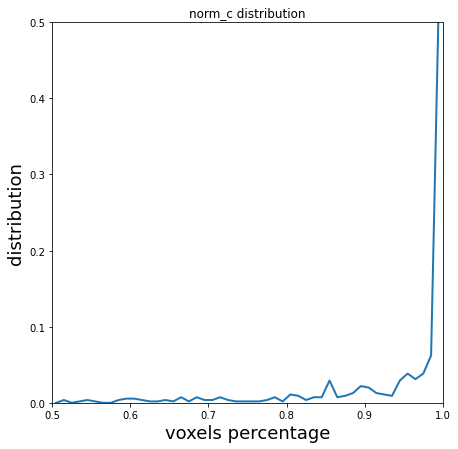

In [ ]:
    # =============================================================================
    # VOXEL DISTRIBUTION ANALYSIS AND CONFIDENCE FILTERING
    # =============================================================================
    
    # Set up binning parameters for analyzing anti-curvature voxel fractions
    bin_interval = 0.01  # Bin width for histogram
    x_lim = [0.5, 1.0]  # Range: 50% to 100% anti-curvature voxels
    bin_number = int((x_lim[1] - x_lim[0]) / bin_interval)
    Antic_voxel_coordinate = np.arange(x_lim[0], x_lim[1], bin_interval) + bin_interval / 2
    
    # Initialize histograms for anti-curvature and normal-curvature GBs
    antic_voxel_num_bin = np.zeros(bin_number)
    normc_voxel_num_bin = np.zeros(bin_number)
    
    # Calculate voxel fraction distribution for anti-curvature GBs
    for index in range(len(GB_antic_list_dV_normD_list)):
        total_voxels = GB_antic_list_dV_normD_list[index] + GB_antic_list_dV_antiD_list[index]
        if total_voxels > 0:  # Avoid division by zero
            antic_fraction = GB_antic_list_dV_antiD_list[index] / total_voxels
            if x_lim[0] <= antic_fraction < x_lim[1]:  # Check if within range
                bin_idx = int((antic_fraction - x_lim[0]) // bin_interval)
                if 0 <= bin_idx < bin_number:  # Ensure valid bin index
                    antic_voxel_num_bin[bin_idx] += 1
    
    # Calculate voxel fraction distribution for normal-curvature GBs
    for index in range(len(GB_normc_list_dV_normD_list)):
        total_voxels = GB_normc_list_dV_normD_list[index] + GB_normc_list_dV_antiD_list[index]
        if total_voxels > 0:
            normc_fraction = GB_normc_list_dV_normD_list[index] / total_voxels
            if x_lim[0] <= normc_fraction < x_lim[1]:
                bin_idx = int((normc_fraction - x_lim[0]) // bin_interval)
                if 0 <= bin_idx < bin_number:
                    normc_voxel_num_bin[bin_idx] += 1
    
    # =============================================================================
    # PLOT NORMAL-CURVATURE VOXEL DISTRIBUTION
    # =============================================================================
    
    figure_name_all_bin = f"figures/2D_normc_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5, 1.0])
    plt.ylim([0, 0.5])
    plt.title("Normal-curvature GB voxel distribution", fontsize=16)
    
    # Plot normalized distribution
    if np.sum(normc_voxel_num_bin) > 0:
        plt.plot(Antic_voxel_coordinate, normc_voxel_num_bin / np.sum(normc_voxel_num_bin), 
                '-', linewidth=2, label='Normal-curvature GBs')
    
    plt.xlabel("Fraction of voxels moving in curvature direction", fontsize=18)
    plt.ylabel("Probability density", fontsize=18)
    plt.legend()
    # plt.savefig(figure_name_all_bin, dpi=400, bbox_inches='tight')
        
    # =============================================================================
    # CONFIDENCE-BASED FILTERING
    # =============================================================================
    
    confidence_factor = 0.99  # 99% confidence threshold for anti-curvature behavior
    
    # Initialize filtered arrays for anti-curvature GBs with high confidence
    update_GB_antic_list_velocity_AllList = []
    update_GB_antic_list_curvature_AllList = []
    update_GB_antic_list_GBenergy_AllList = []
    update_GB_antic_list_anticNum_AllList = []
    update_GB_antic_list_area_AllList = []
    update_GB_antic_list_dV_normD_AllList = []
    update_GB_antic_list_dV_antiD_AllList = []
    
    # Flattened arrays for high-confidence anti-curvature GBs
    update_GB_antic_list_velocity_list = []
    update_GB_antic_list_curvature_list = []
    update_GB_antic_list_GBenergy_list = []
    update_GB_antic_list_anticNum_list = []
    update_GB_antic_list_area_list = []
    update_GB_antic_list_dV_normD_list = []
    update_GB_antic_list_dV_antiD_list = []
    
    # Filter anti-curvature GBs based on confidence factor
    for index in range(len(GB_antic_list_velocity_list)):
        total_voxels = GB_antic_list_dV_normD_list[index] + GB_antic_list_dV_antiD_list[index]
        if total_voxels > 0:
            antic_fraction = GB_antic_list_dV_antiD_list[index] / total_voxels
            if antic_fraction > confidence_factor:  # High confidence anti-curvature
                update_GB_antic_list_velocity_list.append(GB_antic_list_velocity_list[index])
                update_GB_antic_list_curvature_list.append(GB_antic_list_curvature_list[index])
                update_GB_antic_list_GBenergy_list.append(GB_antic_list_GBenergy_list[index])
                update_GB_antic_list_anticNum_list.append(GB_antic_list_anticNum_list[index])
                update_GB_antic_list_area_list.append(GB_antic_list_area_list[index])
                update_GB_antic_list_dV_normD_list.append(GB_antic_list_dV_normD_list[index])
                update_GB_antic_list_dV_antiD_list.append(GB_antic_list_dV_antiD_list[index])
    
    # Filter time-step-wise data (currently empty initialization, would need similar filtering)
    for index_i in range(len(GB_antic_list_velocity_AllList)):
        tmp_update_lists = [[] for _ in range(7)]  # Initialize temporary lists
        
        for index_j in range(len(GB_antic_list_velocity_AllList[index_i])):
            total_voxels = (GB_antic_list_dV_normD_AllList[index_i][index_j] + 
                          GB_antic_list_dV_antiD_AllList[index_i][index_j])
            if total_voxels > 0:
                antic_fraction = GB_antic_list_dV_antiD_AllList[index_i][index_j] / total_voxels
                if antic_fraction > confidence_factor:
                    # Add to filtered lists
                    tmp_update_lists[0].append(GB_antic_list_velocity_AllList[index_i][index_j])
                    tmp_update_lists[1].append(GB_antic_list_curvature_AllList[index_i][index_j])
                    tmp_update_lists[2].append(GB_antic_list_GBenergy_AllList[index_i][index_j])
                    tmp_update_lists[3].append(GB_antic_list_anticNum_AllList[index_i][index_j])
                    tmp_update_lists[4].append(GB_antic_list_area_AllList[index_i][index_j])
                    tmp_update_lists[5].append(GB_antic_list_dV_normD_AllList[index_i][index_j])
                    tmp_update_lists[6].append(GB_antic_list_dV_antiD_AllList[index_i][index_j])
        
        # Store filtered data for this time step
        update_GB_antic_list_velocity_AllList.append(tmp_update_lists[0])
        update_GB_antic_list_curvature_AllList.append(tmp_update_lists[1])
        update_GB_antic_list_GBenergy_AllList.append(tmp_update_lists[2])
        update_GB_antic_list_anticNum_AllList.append(tmp_update_lists[3])
        update_GB_antic_list_area_AllList.append(tmp_update_lists[4])
        update_GB_antic_list_dV_normD_AllList.append(tmp_update_lists[5])
        update_GB_antic_list_dV_antiD_AllList.append(tmp_update_lists[6])
        
    # =============================================================================
    # FILTER NORMAL-CURVATURE GBs WITH HIGH CONFIDENCE
    # =============================================================================
        
    # Similar filtering for normal-curvature GBs
    update_GB_normc_list_velocity_AllList = []
    update_GB_normc_list_curvature_AllList = []
    update_GB_normc_list_GBenergy_AllList = []
    update_GB_normc_list_area_AllList = []
    update_GB_normc_list_dV_normD_AllList = []
    update_GB_normc_list_dV_antiD_AllList = []
    
    update_GB_normc_list_velocity_list = []
    update_GB_normc_list_curvature_list = []
    update_GB_normc_list_GBenergy_list = []
    update_GB_normc_list_area_list = []
    update_GB_normc_list_dV_normD_list = []
    update_GB_normc_list_dV_antiD_list = []
    
    # Filter normal-curvature GBs based on confidence factor
    for index in range(len(GB_normc_list_velocity_list)):
        total_voxels = GB_normc_list_dV_normD_list[index] + GB_normc_list_dV_antiD_list[index]
        if total_voxels > 0:
            normc_fraction = GB_normc_list_dV_normD_list[index] / total_voxels
            if normc_fraction > confidence_factor:  # High confidence normal-curvature
                update_GB_normc_list_velocity_list.append(GB_normc_list_velocity_list[index])
                update_GB_normc_list_curvature_list.append(GB_normc_list_curvature_list[index])
                update_GB_normc_list_GBenergy_list.append(GB_normc_list_GBenergy_list[index])
                update_GB_normc_list_area_list.append(GB_normc_list_area_list[index])
                update_GB_normc_list_dV_normD_list.append(GB_normc_list_dV_normD_list[index])
                update_GB_normc_list_dV_antiD_list.append(GB_normc_list_dV_antiD_list[index])
    
    # Filter time-step-wise normal-curvature data (similar process)
    for index_i in range(len(GB_normc_list_velocity_AllList)):
        tmp_update_lists = [[] for _ in range(6)]  # Initialize temporary lists
        
        for index_j in range(len(GB_normc_list_velocity_AllList[index_i])):
            total_voxels = (GB_normc_list_dV_normD_AllList[index_i][index_j] + 
                          GB_normc_list_dV_antiD_AllList[index_i][index_j])
            if total_voxels > 0:
                normc_fraction = GB_normc_list_dV_normD_AllList[index_i][index_j] / total_voxels
                if normc_fraction > confidence_factor:
                    # Add to filtered lists
                    tmp_update_lists[0].append(GB_normc_list_velocity_AllList[index_i][index_j])
                    tmp_update_lists[1].append(GB_normc_list_curvature_AllList[index_i][index_j])
                    tmp_update_lists[2].append(GB_normc_list_GBenergy_AllList[index_i][index_j])
                    tmp_update_lists[3].append(GB_normc_list_area_AllList[index_i][index_j])
                    tmp_update_lists[4].append(GB_normc_list_dV_normD_AllList[index_i][index_j])
                    tmp_update_lists[5].append(GB_normc_list_dV_antiD_AllList[index_i][index_j])
        
        # Store filtered data for this time step
        update_GB_normc_list_velocity_AllList.append(tmp_update_lists[0])
        update_GB_normc_list_curvature_AllList.append(tmp_update_lists[1])
        update_GB_normc_list_GBenergy_AllList.append(tmp_update_lists[2])
        update_GB_normc_list_area_AllList.append(tmp_update_lists[3])
        update_GB_normc_list_dV_normD_AllList.append(tmp_update_lists[4])
        update_GB_normc_list_dV_antiD_AllList.append(tmp_update_lists[5])

In [ ]:
    # =============================================================================
    # FILTERED STATISTICS ANALYSIS (HIGH-CONFIDENCE DATA)
    # =============================================================================
    
    print("VOXEL-LEVEL STATISTICS (HIGH-CONFIDENCE ANTI-CURVATURE GBs)")
    print("=" * 60)
    
    # Calculate voxel statistics for high-confidence anti-curvature GBs
    normal_growth_voxel = np.sum(update_GB_antic_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_antic_list_dV_antiD_list)
    total_voxels = normal_growth_voxel + antic_growth_voxel
    
    print(f"Normal voxels: {normal_growth_voxel}")
    print(f"Anti-curvature voxels: {antic_growth_voxel}")
    print(f"Total voxels: {total_voxels}")
    if total_voxels > 0:
        print(f"Anti-curvature voxel fraction: {antic_growth_voxel/total_voxels*100:.2f}%")
    print()
    
    print("VOXEL-LEVEL STATISTICS (HIGH-CONFIDENCE NORMAL-CURVATURE GBs)")
    print("=" * 60)
    
    # Calculate voxel statistics for high-confidence normal-curvature GBs
    normal_growth_voxel = np.sum(update_GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_normc_list_dV_antiD_list)
    total_voxels = normal_growth_voxel + antic_growth_voxel
    
    print(f"Normal voxels: {normal_growth_voxel}")
    print(f"Anti-curvature voxels: {antic_growth_voxel}")
    print(f"Total voxels: {total_voxels}")
    if total_voxels > 0:
        print(f"Normal-curvature voxel fraction: {normal_growth_voxel/total_voxels*100:.2f}%")
    print()

    print("GB-LEVEL STATISTICS COMPARISON")
    print("=" * 40)
    
    # Calculate total GB numbers for comparison
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print("BEFORE CONFIDENCE FILTERING:")
    print(f"Anti-curvature GBs: {len(GB_antic_list_dV_normD_list)} ({len(GB_antic_list_dV_normD_list)/total_GB_num_real*100:.2f}%)")
    print(f"Normal-curvature GBs: {len(GB_normc_list_dV_normD_list)} ({len(GB_normc_list_dV_normD_list)/total_GB_num_real*100:.2f}%)")
    print(f"Total filtered GBs: {total_GB_num_real}")
    print()
    
    print("AFTER CONFIDENCE FILTERING (99% threshold):")
    print(f"High-confidence anti-curvature GBs: {len(update_GB_antic_list_dV_antiD_list)} ({len(update_GB_antic_list_dV_antiD_list)/total_GB_num_real*100:.2f}%)")
    print(f"High-confidence normal-curvature GBs: {len(update_GB_normc_list_dV_antiD_list)} ({len(update_GB_normc_list_dV_antiD_list)/total_GB_num_real*100:.2f}%)")
    print()
    
    print("PERCENTAGE OF ORIGINAL TOTAL GBs:")
    print(f"High-confidence anti-curvature GBs: {len(update_GB_antic_list_dV_antiD_list)/total_GB_num*100:.3f}%")
    print(f"High-confidence normal-curvature GBs: {len(update_GB_normc_list_dV_antiD_list)/total_GB_num*100:.3f}%")
    print(f"Original total GBs: {total_GB_num}")
    print()

Voxels on anti-c GBs
The number of the normal voxels and antic voxels during whole simulations are 0.0 and 0.0

Voxels on norm-c GBs
The number of the normal voxels and antic voxels during whole simulations are 73075 and 41
The ratio of norm-curvature voxels during whole simulations is 99.94392472235899% in 73116 voxels

anti-c GB before removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 0
The ratio of anti-curvature and norm GBs during whole simulations is 0.0% and 100.0% in 547 GBs

anti-c GB after removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 0
The ratio of anti-curvature and norm GBs during whole simulations is 0.0% and 53.56489945155393% in 547 GBs

The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) 0.0% and 0.10568727388153647% in 277233 GBs



all points fitting: 0.5851302788570785
all points slope: 2.2952265467306354
smaller points fitting: 0.5851302788570785
smaller points slope: 2.2952265467306354


<Figure size 432x288 with 0 Axes>

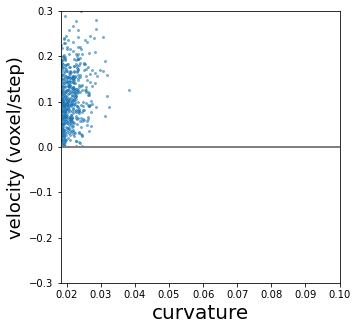

<Figure size 432x288 with 0 Axes>

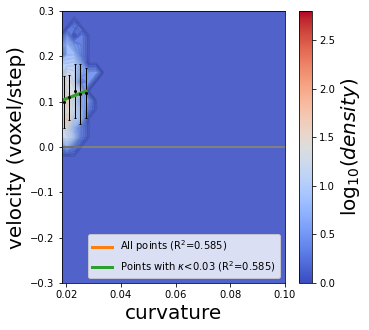

In [ ]:
    # =============================================================================
    # VELOCITY vs CURVATURE RELATIONSHIP ANALYSIS
    # =============================================================================
    
    # Create comprehensive scatter plot showing all GB data
    figure_name_all = f"figures/2D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    
    # Plot reference line at velocity = 0
    plt.plot([curvature_limit, 0.5], [0, 0], '-', color='grey', linewidth=2, alpha=0.7, label='V=0 reference')
    
    # Scatter plot: normal-curvature GBs (blue) and anti-curvature GBs (orange)
    plt.scatter(GB_normc_list_curvature_list, GB_normc_list_velocity_list, 
                s=4, alpha=0.5, label='Normal-curvature GBs', color='C0')
    plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list, 
                s=4, alpha=0.5, color='C1', label='Anti-curvature GBs')
    
    plt.xlabel("Curvature κ", fontsize=20)
    plt.ylabel("Velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit, 0.1])
    plt.ylim([-0.3, 0.3])
    plt.legend()
    plt.title("GB Velocity vs Curvature", fontsize=16)
    plt.savefig(figure_name_all, dpi=400, bbox_inches='tight')
    
    # =============================================================================
    # DENSITY PLOT WITH STATISTICAL ANALYSIS
    # =============================================================================
    
    # Create 2D histogram for density visualization
    x_bins = np.linspace(0, 0.105, 40)  # Curvature bins
    y_bins = np.linspace(-0.4, 0.4, 40)  # Velocity bins
    
    # Combine all GB data for density analysis
    all_curvatures = GB_normc_list_curvature_list + GB_antic_list_curvature_list
    all_velocities = GB_normc_list_velocity_list + GB_antic_list_velocity_list
    
    hist, x_edges, y_edges = np.histogram2d(all_curvatures, all_velocities, bins=[x_bins, y_bins])
    
    # Compute bin centers for plotting
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    # =============================================================================
    # BINNED STATISTICAL ANALYSIS
    # =============================================================================
    
    # Set up fine binning for statistical analysis
    bin_interval = 0.002  # Fine bin width
    x_lim = [0, 0.1]  # Curvature range
    bin_number = int((x_lim[1] - x_lim[0]) / bin_interval)
    curvature_coordinate = np.arange(x_lim[0], x_lim[1], bin_interval) + bin_interval / 2
    
    # Combine data for analysis
    new_curvature_1Dlist_remove_0step = GB_normc_list_curvature_list + GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = GB_normc_list_velocity_list + GB_antic_list_velocity_list
    new_area_1Dlist_remove_0step = GB_normc_list_area_list + GB_antic_list_area_list
    new_GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list + GB_antic_list_GBenergy_list
    
    # Calculate binned statistics (mean and standard deviation)
    curvature_bin_counts = np.zeros(bin_number)
    velocity_bin_sums = np.zeros(bin_number)
    velocity_bin_squared_sums = np.zeros(bin_number)
    
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        curvature_val = new_curvature_1Dlist_remove_0step[index]
        velocity_val = new_velocity_1Dlist_remove_0step[index]
        
        if abs(curvature_val) > x_lim[1]:  # Skip high curvature values
            continue
            
        bin_idx = int((curvature_val - x_lim[0]) // bin_interval)
        if 0 <= bin_idx < bin_number:
            curvature_bin_counts[bin_idx] += 1
            velocity_bin_sums[bin_idx] += velocity_val
            velocity_bin_squared_sums[bin_idx] += velocity_val ** 2

    # Calculate means and standard deviations
    velocity_bin_means = np.zeros(bin_number)
    velocity_bin_stds = np.zeros(bin_number)

    for i in range(bin_number):
        if curvature_bin_counts[i] > 0:
            velocity_bin_means[i] = velocity_bin_sums[i] / curvature_bin_counts[i]
            # Standard deviation calculation
            mean_squared = velocity_bin_means[i] ** 2
            mean_of_squares = velocity_bin_squared_sums[i] / curvature_bin_counts[i]
            velocity_bin_stds[i] = np.sqrt(mean_of_squares - mean_squared)
    
    # =============================================================================
    # ADVANCED DENSITY PLOT WITH LINEAR FITTING
    # =============================================================================
    
    figure_name_all = f"figures/2D_velocity_signedcurvature_hot_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    
    # Plot reference line
    plt.plot([curvature_limit, 0.5], [0, 0], '-', color='grey', linewidth=2, alpha=0.7)
    
    # Create density contour plot
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T == 0] = 1  # Avoid log(0) issues
    
    # Plot density with log scale
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1, vmin=0, vmax=2.8)
    ax2 = plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9, vmin=0, vmax=2.8)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=2.8))
    cbar = plt.colorbar(sm)
    cbar.set_label(u"$\log_{10}(density)$", fontsize=20)
    
    # =============================================================================
    # STATISTICAL ERROR BARS AND LINEAR FITTING
    # =============================================================================
    
    # Plot error bars for bins with sufficient data
    valid_bins = curvature_bin_counts > 10  # Minimum 10 data points per bin
    plt.errorbar(curvature_coordinate[valid_bins], velocity_bin_means[valid_bins], 
                yerr=velocity_bin_stds[valid_bins],
                fmt='o', color='k', linewidth=1, capsize=1, ecolor='black', markersize=2,
                label='Binned statistics')
    
    # Linear fit for all valid bins
    x_all = curvature_coordinate[valid_bins]
    y_all = velocity_bin_means[valid_bins]
    
    if len(x_all) > 1:  # Need at least 2 points for fitting
        p_all = np.polyfit(x_all, y_all, 1)  # Linear fit
        y_pred_all = np.polyval(p_all, x_all)
        r2_all = 1 - np.sum((y_all - y_pred_all)**2) / np.sum((y_all - np.mean(y_all))**2)
        print(f"All points fitting R²: {r2_all:.4f}")
        print(f"All points slope (mobility): {p_all[0]:.6f}")
        
        # Linear fit for low curvature region (κ < 0.03)
        mask_sub = x_all < 0.03
        x_sub = x_all[mask_sub]
        y_sub = y_all[mask_sub]
        
        if len(x_sub) > 1:
            p_sub = np.polyfit(x_sub, y_sub, 1)
            y_pred_sub = np.polyval(p_sub, x_sub)
            r2_sub = 1 - np.sum((y_sub - y_pred_sub)**2) / np.sum((y_sub - np.mean(y_sub))**2)
            print(f"Low curvature (κ<0.03) fitting R²: {r2_sub:.4f}")
            print(f"Low curvature slope (mobility): {p_sub[0]:.6f}")
        else:
            r2_sub = np.nan
            p_sub = [np.nan, np.nan]
        
        # Plot linear fits
        plt.plot(x_all, y_pred_all, '-', color='C1', linewidth=3, 
                label=rf'All points (R$^2$={r2_all:.3f})')
        if len(x_sub) > 1:
            plt.plot(x_sub, y_pred_sub, '-', color='C2', linewidth=3, 
                    label=rf'κ<0.03 (R$^2$={r2_sub:.3f})')
        
        plt.legend(loc='lower right')
    
    plt.xlabel("Curvature κ", fontsize=20)
    plt.ylabel("Velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit, 0.1])
    plt.ylim([-0.3, 0.3])
    plt.title("GB Velocity vs Curvature (Density Plot)", fontsize=14)
    plt.savefig(figure_name_all, dpi=400, bbox_inches='tight')

Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

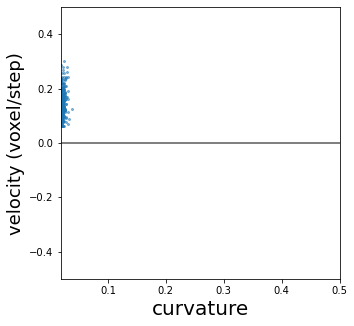

<Figure size 432x288 with 0 Axes>

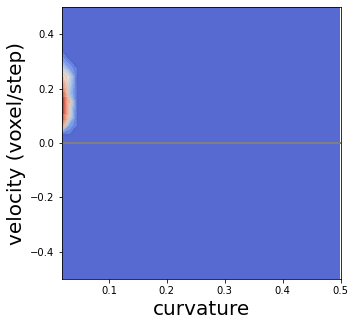

<Figure size 432x288 with 0 Axes>

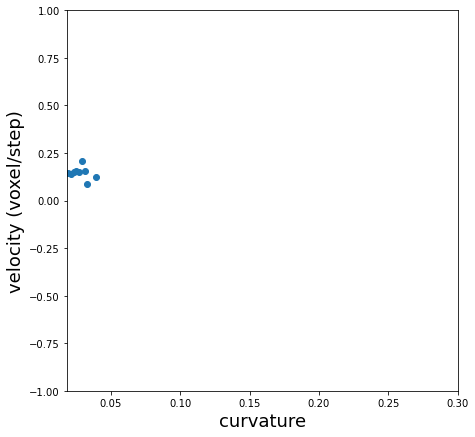

In [ ]:
    # =============================================================================
    # HIGH-CONFIDENCE FILTERED DATA VISUALIZATION
    # =============================================================================
    
    # Create scatter plot for high-confidence filtered data
    figure_name_all = f"figures/2D_velocity_signedcurvature_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    
    # Plot reference line at velocity = 0
    plt.plot([curvature_limit, 0.5], [0, 0], '-', color='grey', linewidth=2, alpha=0.7)
    
    # Scatter plot for high-confidence data
    plt.scatter(update_GB_normc_list_curvature_list, update_GB_normc_list_velocity_list, 
                s=4, alpha=0.5, label='High-confidence normal-curvature GBs')
    plt.scatter(update_GB_antic_list_curvature_list, update_GB_antic_list_velocity_list, 
                s=4, alpha=0.5, color='C1', label='High-confidence anti-curvature GBs')
    
    plt.xlabel("Curvature κ", fontsize=20)
    plt.ylabel("Velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit, 0.5])
    plt.ylim([-0.5, 0.5])
    plt.legend()
    plt.title("High-Confidence GB Data (99% threshold)", fontsize=14)
    plt.savefig(figure_name_all, dpi=400, bbox_inches='tight')
    
    # =============================================================================
    # HIGH-CONFIDENCE DENSITY PLOT
    # =============================================================================
    
    # Create 2D histogram for high-confidence filtered data
    x_bins = np.linspace(0, 0.505, 40)  # Extended curvature range
    y_bins = np.linspace(-0.6, 0.6, 40)  # Extended velocity range
    
    # Combine high-confidence data
    filtered_curvatures = update_GB_normc_list_curvature_list + update_GB_antic_list_curvature_list
    filtered_velocities = update_GB_normc_list_velocity_list + update_GB_antic_list_velocity_list
    
    hist, x_edges, y_edges = np.histogram2d(filtered_curvatures, filtered_velocities, bins=[x_bins, y_bins])
    
    # Compute bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/2D_velocity_signedcurvature_confi_hot_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    
    # Plot reference line
    plt.plot([curvature_limit, 0.5], [0, 0], '-', color='grey', linewidth=2, alpha=0.7)
    
    # Create density plot
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T == 0] = 0.5  # Set minimum value for log plot
    
    plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9)
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1)
    
    plt.xlabel("Curvature κ", fontsize=20)
    plt.ylabel("Velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit, 0.5])
    plt.ylim([-0.5, 0.5])
    plt.title("High-Confidence Density Plot", fontsize=14)
    plt.savefig(figure_name_all, dpi=400, bbox_inches='tight')
    
    # =============================================================================
    # BINNED ANALYSIS FOR HIGH-CONFIDENCE DATA
    # =============================================================================
    
    # Set up binning parameters for detailed analysis
    bin_interval = 0.002
    x_lim = [0.0, 0.5]  # Extended range for high-confidence data
    bin_number = int((x_lim[1] - x_lim[0]) / bin_interval)
    curvature_coordinate = np.arange(x_lim[0], x_lim[1], bin_interval) + bin_interval / 2

    # Initialize binning arrays
    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    
    # Combine high-confidence data for analysis
    new_curvature_1Dlist_remove_0step = update_GB_normc_list_curvature_list + update_GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = update_GB_normc_list_velocity_list + update_GB_antic_list_velocity_list
    new_area_1Dlist_remove_0step = update_GB_normc_list_area_list + update_GB_antic_list_area_list
    new_GBenergy_1Dlist_remove_0step = update_GB_normc_list_GBenergy_list + update_GB_antic_list_GBenergy_list
    
    # Bin the data
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        curvature_val = new_curvature_1Dlist_remove_0step[index]
        velocity_val = new_velocity_1Dlist_remove_0step[index]
        
        # Check if within analysis range
        if abs(curvature_val) >= x_lim[1] or abs(curvature_val) <= x_lim[0]: 
            continue
            
        bin_idx = int((curvature_val - x_lim[0]) // bin_interval)
        if 0 <= bin_idx < bin_number:
            curvature_bin[bin_idx] += 1  # Count data points in bin
            velocity_bin[bin_idx] += velocity_val  # Sum velocities in bin
    
    # Calculate average velocity per bin
    for i in range(bin_number):
        if curvature_bin[i] > 0:
            velocity_bin[i] = velocity_bin[i] / curvature_bin[i]
    
    # =============================================================================
    # PLOT BINNED RESULTS
    # =============================================================================
    
    figure_name_all_bin = f"figures/2D_velocity_signedcurvature_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    
    # Plot only bins with data
    valid_bins = velocity_bin != 0
    plt.plot(curvature_coordinate[valid_bins], velocity_bin[valid_bins], 'o', 
             linewidth=2, markersize=6, label='Binned averages')
    
    plt.xlim([curvature_limit, 0.3])
    plt.ylim([-1, 1])
    plt.xlabel("Curvature κ", fontsize=18)
    plt.ylabel("Average velocity (voxel/step)", fontsize=18)
    plt.title("Binned Velocity vs Curvature (High-Confidence)", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    # plt.savefig(figure_name_all_bin, dpi=400, bbox_inches='tight')

Text(0, 0.5, 'area')

<Figure size 432x288 with 0 Axes>

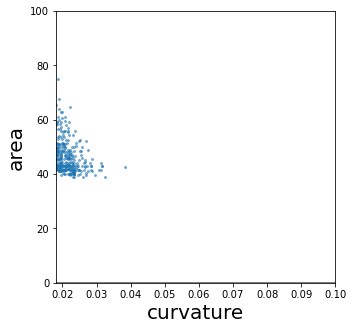

<Figure size 432x288 with 0 Axes>

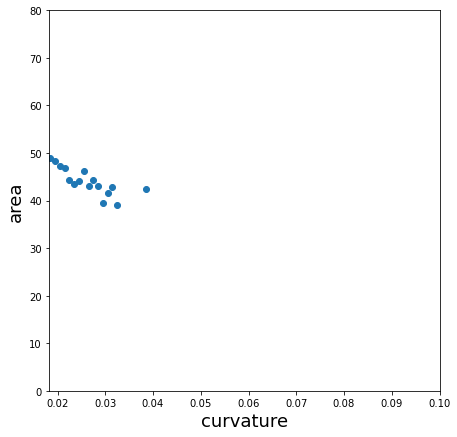

In [ ]:
    # =============================================================================
    # CURVATURE vs AREA RELATIONSHIP ANALYSIS
    # =============================================================================
    
    # Create scatter plot showing relationship between curvature and GB area
    figure_name_all = f"figures/2D_signedcurvature_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    
    # Plot reference line at area = 0
    plt.plot([curvature_limit, 0.1], [0, 0], '-', color='grey', linewidth=2, alpha=0.7)
    
    # Scatter plot: curvature vs area
    plt.scatter(new_curvature_1Dlist_remove_0step, new_area_1Dlist_remove_0step, 
                s=4, alpha=0.5, color='C0', label='All filtered GBs')
    
    plt.xlabel("Curvature κ", fontsize=20)
    plt.ylabel("GB Area (voxels)", fontsize=20)
    plt.xlim([curvature_limit, 0.1])
    plt.ylim([0, 100])
    plt.title("Curvature vs GB Area", fontsize=16)
    plt.legend()
    # plt.savefig(figure_name_all, dpi=400, bbox_inches='tight')
    
    # =============================================================================
    # BINNED AREA ANALYSIS
    # =============================================================================
    
    # Set up binning for area vs curvature analysis
    bin_interval = 0.001  # Fine binning for detailed analysis
    x_lim = [0.0, 0.1]  # Curvature range
    bin_number = int((x_lim[1] - x_lim[0]) / bin_interval)
    curvature_coordinate = np.arange(x_lim[0], x_lim[1], bin_interval) + bin_interval / 2

    # Initialize binning arrays
    curvature_bin = np.zeros(bin_number)  # Count of GBs per bin
    area_bin = np.zeros(bin_number)  # Sum of areas per bin
    
    # Bin the curvature-area data
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        curvature_val = new_curvature_1Dlist_remove_0step[index]
        area_val = new_area_1Dlist_remove_0step[index]
        
        if abs(curvature_val) > 0.1:  # Skip high curvature values
            continue
            
        bin_idx = int((curvature_val - x_lim[0]) // bin_interval)
        if 0 <= bin_idx < bin_number:
            curvature_bin[bin_idx] += 1  # Count GBs in this bin
            area_bin[bin_idx] += area_val  # Sum areas in this bin
    
    # Calculate average area per curvature bin
    for i in range(bin_number):
        if curvature_bin[i] > 0:
            area_bin[i] = area_bin[i] / curvature_bin[i]
    
    # =============================================================================
    # PLOT BINNED AREA RESULTS
    # =============================================================================
    
    figure_name_all_bin = f"figures/2D_signedcurvature_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    
    # Plot only bins with data
    valid_bins = area_bin != 0
    plt.plot(curvature_coordinate[valid_bins], area_bin[valid_bins], 'o', 
             linewidth=2, markersize=6, color='C2', label='Average area per bin')
    
    plt.xlim([curvature_limit, 0.1])
    plt.ylim([0, 80])
    plt.xlabel("Curvature κ", fontsize=18)
    plt.ylabel("Average GB Area (voxels)", fontsize=18)
    plt.title("Binned Analysis: Curvature vs Area", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add trend interpretation
    if len(curvature_coordinate[valid_bins]) > 1:
        # Simple trend analysis
        x_trend = curvature_coordinate[valid_bins]
        y_trend = area_bin[valid_bins]
        correlation = np.corrcoef(x_trend, y_trend)[0, 1]
        plt.text(0.02, 70, f'Correlation: {correlation:.3f}', fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # plt.savefig(figure_name_all_bin, dpi=400, bbox_inches='tight')

Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

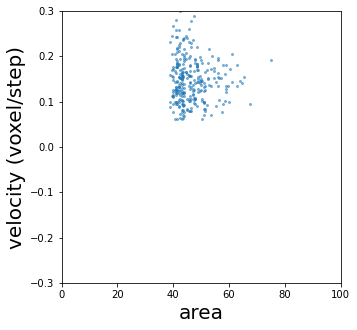

<Figure size 432x288 with 0 Axes>

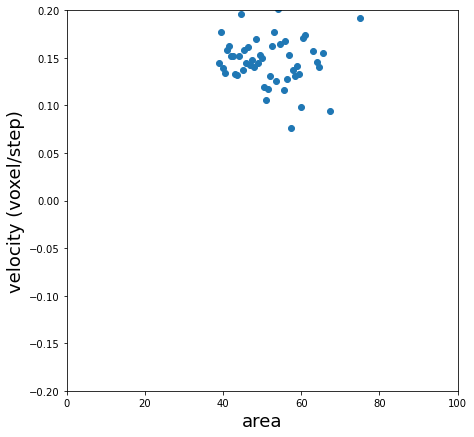

In [ ]:
    # =============================================================================
    # VELOCITY vs AREA RELATIONSHIP ANALYSIS
    # =============================================================================
    
    # Create scatter plot showing relationship between velocity and GB area
    figure_name_all = f"figures/2D_velocity_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    
    # Scatter plot: area vs velocity
    plt.scatter(new_area_1Dlist_remove_0step, new_velocity_1Dlist_remove_0step, 
                s=4, alpha=0.5, color='C0', label='All filtered GBs')
    
    plt.xlabel("GB Area (voxels)", fontsize=20)
    plt.ylabel("Velocity (voxel/step)", fontsize=20)
    plt.xlim([0, 100])
    plt.ylim([-0.3, 0.3])
    plt.title("Velocity vs GB Area", fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    # plt.savefig(figure_name_all, dpi=400, bbox_inches='tight')
    
    # =============================================================================
    # BINNED VELOCITY vs AREA ANALYSIS
    # =============================================================================
    
    # Set up binning for area vs velocity analysis
    bin_interval = 0.1  # Area bin width (in voxels)
    x_lim = [0.0, 100]  # Area range
    bin_number = int((x_lim[1] - x_lim[0]) / bin_interval)
    area_coordinate = np.arange(x_lim[0], x_lim[1], bin_interval) + bin_interval / 2

    # Initialize binning arrays
    area_bin = np.zeros(bin_number)  # Count of GBs per area bin
    velocity_bin = np.zeros(bin_number)  # Sum of velocities per area bin
    antic_num_bin = np.zeros(bin_number)  # Count of anti-curvature GBs per area bin
    
    # Bin the area-velocity data
    for index in range(len(new_area_1Dlist_remove_0step)):
        area_val = new_area_1Dlist_remove_0step[index]
        velocity_val = new_velocity_1Dlist_remove_0step[index]
        
        if abs(area_val) > x_lim[1]:  # Skip very large areas
            continue
            
        bin_idx = int((area_val - x_lim[0]) // bin_interval)
        if 0 <= bin_idx < bin_number:
            area_bin[bin_idx] += 1  # Count GBs in this area bin
            velocity_bin[bin_idx] += velocity_val  # Sum velocities
            
            # Count anti-curvature instances (negative velocity indicates anti-curvature)
            if velocity_val < 0:
                antic_num_bin[bin_idx] += 1
    
    # Calculate average velocity per area bin
    for i in range(bin_number):
        if area_bin[i] > 0:
            velocity_bin[i] = velocity_bin[i] / area_bin[i]
    
    # =============================================================================
    # PLOT BINNED VELOCITY vs AREA RESULTS
    # =============================================================================
    
    figure_name_all_bin = f"figures/2D_velocity_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    
    # Plot only bins with data
    valid_bins = velocity_bin != 0
    plt.plot(area_coordinate[valid_bins], velocity_bin[valid_bins], 'o', 
             linewidth=2, markersize=6, color='C3', label='Average velocity per area bin')
    
    plt.xlim([0, 100])
    plt.ylim([-0.2, 0.2])
    plt.xlabel("GB Area (voxels)", fontsize=18)
    plt.ylabel("Average Velocity (voxel/step)", fontsize=18)
    plt.title("Binned Analysis: Velocity vs Area", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add trend line if sufficient data
    if len(area_coordinate[valid_bins]) > 1:
        x_trend = area_coordinate[valid_bins]
        y_trend = velocity_bin[valid_bins]
        correlation = np.corrcoef(x_trend, y_trend)[0, 1]
        plt.text(20, 0.15, f'Correlation: {correlation:.3f}', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # plt.savefig(figure_name_all_bin, dpi=400, bbox_inches='tight')

Text(0, 0.5, 'anti-curvature fraction')

<Figure size 432x288 with 0 Axes>

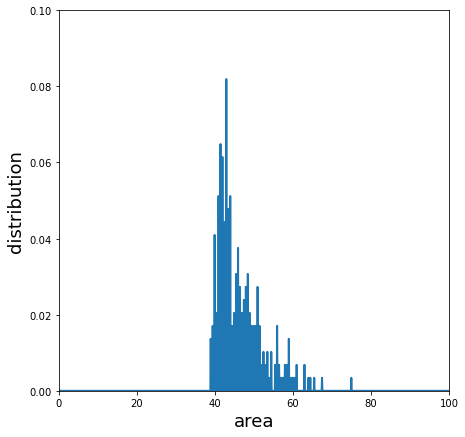

<Figure size 432x288 with 0 Axes>

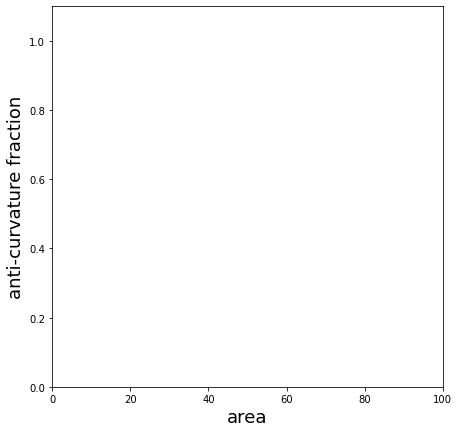

In [ ]:
    # =============================================================================
    # AREA DISTRIBUTION AND ANTI-CURVATURE FRACTION ANALYSIS
    # =============================================================================
    
    # Plot the distribution of GB areas
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0, 100])
    plt.ylim([0, 0.1])
    
    # Normalize area distribution to show probability density
    total_area_bins = np.sum(area_bin)
    if total_area_bins > 0:
        plt.plot(area_coordinate, area_bin / total_area_bins, '-', linewidth=2, 
                color='C4', label='Area distribution')
    
    plt.xlabel("GB Area (voxels)", fontsize=18)
    plt.ylabel("Probability density", fontsize=18)
    plt.title("Distribution of GB Areas", fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # =============================================================================
    # ANTI-CURVATURE FRACTION vs AREA ANALYSIS
    # =============================================================================
    
    # Calculate anti-curvature fraction per area bin
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(area_bin)):
        if area_bin[bin_i] > 0:  # Avoid division by zero
            antic_ratio_bin[bin_i] = antic_num_bin[bin_i] / area_bin[bin_i]
    
    # Plot anti-curvature fraction vs area
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0, 100])
    plt.ylim([0, 1.1])
    
    # Plot only bins with data
    valid_ratio_bins = antic_ratio_bin > 0
    plt.plot(area_coordinate[valid_ratio_bins], antic_ratio_bin[valid_ratio_bins], 'o', 
             linewidth=2, markersize=6, color='C5', label='Anti-curvature fraction')
    
    # Add reference lines
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='50% threshold')
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='100% anti-curvature')
    
    plt.xlabel("GB Area (voxels)", fontsize=18)
    plt.ylabel("Anti-curvature fraction", fontsize=18)
    plt.title("Anti-curvature Fraction vs GB Area", fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Statistical analysis of area dependence
    if len(area_coordinate[valid_ratio_bins]) > 1:
        x_area = area_coordinate[valid_ratio_bins]
        y_ratio = antic_ratio_bin[valid_ratio_bins]
        
        # Calculate correlation between area and anti-curvature fraction
        correlation = np.corrcoef(x_area, y_ratio)[0, 1]
        
        # Calculate statistics
        mean_ratio = np.mean(y_ratio)
        std_ratio = np.std(y_ratio)
        
        # Add statistics to plot
        stats_text = f'Mean fraction: {mean_ratio:.3f}\nStd deviation: {std_ratio:.3f}\nCorrelation: {correlation:.3f}'
        plt.text(60, 0.2, stats_text, fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        print(f"AREA vs ANTI-CURVATURE FRACTION STATISTICS:")
        print(f"Mean anti-curvature fraction: {mean_ratio:.3f}")
        print(f"Standard deviation: {std_ratio:.3f}")
        print(f"Correlation (area vs anti-curvature fraction): {correlation:.3f}")
        
        # Identify area ranges with high anti-curvature behavior
        high_antic_mask = y_ratio > 0.7  # Areas with >70% anti-curvature
        if np.any(high_antic_mask):
            high_antic_areas = x_area[high_antic_mask]
            print(f"Area ranges with high anti-curvature (>70%): {high_antic_areas.min():.1f} - {high_antic_areas.max():.1f} voxels")

Text(0, 0.5, 'distribution')

<Figure size 432x288 with 0 Axes>

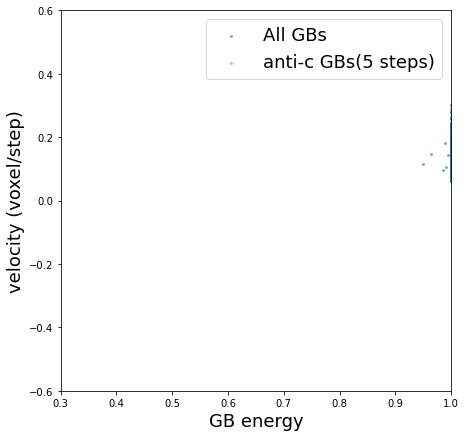

<Figure size 432x288 with 0 Axes>

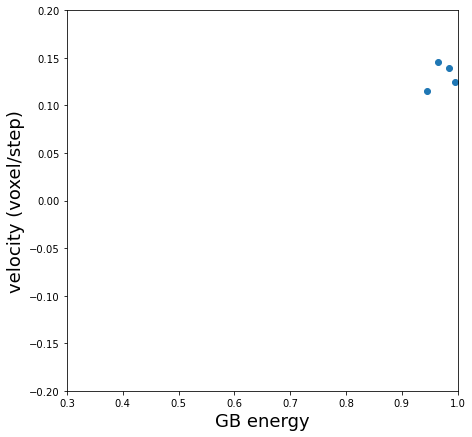

<Figure size 432x288 with 0 Axes>

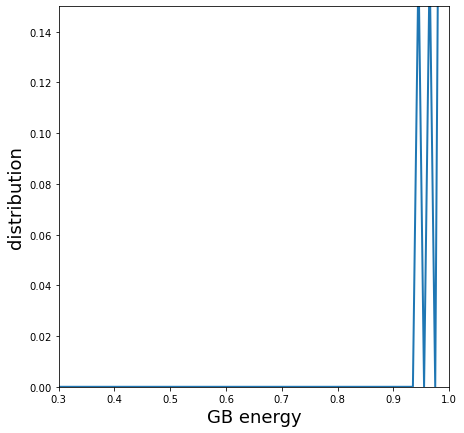

In [ ]:
    # =============================================================================
    # VELOCITY vs GRAIN BOUNDARY ENERGY ANALYSIS
    # =============================================================================
    
    # Create scatter plot showing velocity vs GB energy relationship
    figure_name_all = f"figures/2D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    
    # Scatter plot for all GBs
    plt.scatter(new_GBenergy_1Dlist_remove_0step, new_velocity_1Dlist_remove_0step, 
                s=4, alpha=0.5, label='All GBs', color='C0')
    
    # Highlight high-confidence anti-curvature GBs with multiple occurrences
    update_GB_antic_list_GBenergy_list = np.array(update_GB_antic_list_GBenergy_list)
    update_GB_antic_list_velocity_list = np.array(update_GB_antic_list_velocity_list)
    update_GB_antic_list_anticNum_list = np.array(update_GB_antic_list_anticNum_list)
    
    # Filter for GBs with at least 5 anti-curvature occurrences (persistent behavior)
    persistent_mask = update_GB_antic_list_anticNum_list >= 5
    plt.scatter(update_GB_antic_list_GBenergy_list[persistent_mask], 
                update_GB_antic_list_velocity_list[persistent_mask],
                s=4, alpha=0.5, color='C1', label='Persistent anti-curvature GBs (≥5 steps)')
    
    plt.xlabel("GB Energy", fontsize=18)
    plt.ylabel("Velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3, 1.0])
    plt.ylim([-0.6, 0.6])
    plt.title("GB Velocity vs Energy", fontsize=16)
    plt.legend(fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.savefig(figure_name_all, dpi=400, bbox_inches='tight')
    
    # =============================================================================
    # BINNED VELOCITY vs ENERGY ANALYSIS
    # =============================================================================
    
    # Set up binning for energy vs velocity analysis
    bin_interval = 0.01  # Energy bin width
    x_lim = [0.25, 1.0]  # Energy range
    bin_number = int((x_lim[1] - x_lim[0]) / bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0], x_lim[1], bin_interval) + bin_interval / 2

    # Initialize binning arrays
    GBenergy_bin = np.zeros(bin_number)  # Count of GBs per energy bin
    velocity_bin = np.zeros(bin_number)  # Sum of velocities per energy bin
    
    # Bin the energy-velocity data
    for index in range(len(new_GBenergy_1Dlist_remove_0step)):
        energy_val = new_GBenergy_1Dlist_remove_0step[index]
        velocity_val = new_velocity_1Dlist_remove_0step[index]
        
        if abs(energy_val) >= 1.0:  # Skip very high energy values
            continue
            
        bin_idx = int((energy_val - x_lim[0]) // bin_interval)
        if 0 <= bin_idx < bin_number:
            GBenergy_bin[bin_idx] += 1  # Count GBs in this energy bin
            velocity_bin[bin_idx] += velocity_val  # Sum velocities
            
        # Debug: check for negative bin indices
        if bin_idx < 0:
            print(f"Warning: Negative bin index for energy {energy_val}")
    
    # Calculate average velocity per energy bin
    for i in range(bin_number):
        if GBenergy_bin[i] > 0:
            velocity_bin[i] = velocity_bin[i] / GBenergy_bin[i]
    
    # =============================================================================
    # PLOT BINNED ENERGY ANALYSIS RESULTS
    # =============================================================================
    
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    
    # Plot only bins with data
    valid_bins = velocity_bin != 0
    plt.plot(GBenergy_coordinate[valid_bins], velocity_bin[valid_bins], 'o', 
             linewidth=2, markersize=6, color='C6', label='Average velocity per energy bin')
    
    plt.xlim([0.3, 1.0])
    plt.ylim([-0.2, 0.2])
    plt.xlabel("GB Energy", fontsize=18)
    plt.ylabel("Average Velocity (voxel/step)", fontsize=18)
    plt.title("Binned Analysis: Velocity vs GB Energy", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add trend analysis
    if len(GBenergy_coordinate[valid_bins]) > 1:
        x_energy = GBenergy_coordinate[valid_bins]
        y_vel = velocity_bin[valid_bins]
        correlation = np.corrcoef(x_energy, y_vel)[0, 1]
        
        plt.text(0.35, 0.15, f'Correlation: {correlation:.3f}', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.savefig(figure_name_all_bin, dpi=400, bbox_inches='tight')
    
    # =============================================================================
    # GB ENERGY DISTRIBUTION ANALYSIS
    # =============================================================================
    
    # Plot the distribution of GB energies
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3, 1.0])
    plt.ylim([0, 0.15])
    
    # Normalize energy distribution
    total_energy_bins = np.sum(GBenergy_bin)
    if total_energy_bins > 0:
        plt.plot(GBenergy_coordinate, GBenergy_bin / total_energy_bins, '-', 
                linewidth=2, color='C7', label='Energy distribution')
    
    plt.xlabel("GB Energy", fontsize=18)
    plt.ylabel("Probability density", fontsize=18)
    plt.title("Distribution of GB Energies", fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Statistical analysis
    if total_energy_bins > 0:
        # Calculate weighted mean and standard deviation
        weights = GBenergy_bin / total_energy_bins
        mean_energy = np.sum(GBenergy_coordinate * weights)
        var_energy = np.sum(weights * (GBenergy_coordinate - mean_energy)**2)
        std_energy = np.sqrt(var_energy)
        
        print(f"GB ENERGY DISTRIBUTION STATISTICS:")
        print(f"Mean GB energy: {mean_energy:.3f}")
        print(f"Standard deviation: {std_energy:.3f}")
        print(f"Energy range: {GBenergy_coordinate[GBenergy_bin > 0].min():.3f} - {GBenergy_coordinate[GBenergy_bin > 0].max():.3f}")
        
        # Add statistics to plot
        stats_text = f'Mean: {mean_energy:.3f}\nStd: {std_energy:.3f}'
        plt.text(0.8, 0.12, stats_text, fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

FloatingPointError: invalid value encountered in divide

<Figure size 432x288 with 0 Axes>

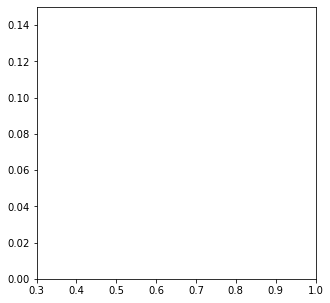

In [ ]:
    # =============================================================================
    # TEMPORAL EVOLUTION OF GB ENERGY DISTRIBUTION
    # =============================================================================
    
    # Compare energy distributions between initial and final simulation steps
    figure_name_distri = f"figures/2D_one_step_distribution_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    
    # Define time steps for comparison
    first_step = 0    # Initial step
    second_step = -1  # Final step (using negative indexing)
    
    # Calculate energy distribution for first time step
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        energy_val = GB_list_GBenergy_list[first_step][index]
        if abs(energy_val) > 1.0:  # Skip high energy outliers
            continue
        bin_idx = int((energy_val - x_lim[0]) // bin_interval)
        if 0 <= bin_idx < bin_number:
            GBenergy_bin_first[bin_idx] += 1
    
    # Calculate energy distribution for final time step
    GBenergy_bin_second = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        energy_val = GB_list_GBenergy_list[second_step][index]
        if abs(energy_val) > 1.0:  # Skip high energy outliers
            continue
        bin_idx = int((energy_val - x_lim[0]) // bin_interval)
        if 0 <= bin_idx < bin_number:
            GBenergy_bin_second[bin_idx] += 1
    
    # Normalize distributions
    total_first = np.sum(GBenergy_bin_first)
    total_second = np.sum(GBenergy_bin_second)
    
    plt.xlim([0.3, 1.0])
    plt.ylim([0, 0.15])
    
    if total_first > 0:
        plt.plot(GBenergy_coordinate, GBenergy_bin_first / total_first, '-', 
                linewidth=2, label="Initial step (t=0)", color='C0')
    if total_second > 0:
        plt.plot(GBenergy_coordinate, GBenergy_bin_second / total_second, '-', 
                linewidth=2, label="Final step", color='C1')
    
    plt.legend(fontsize=18)
    plt.xlabel("GB Energy", fontsize=18)
    plt.ylabel("Probability density", fontsize=18)
    plt.title("Temporal Evolution of GB Energy Distribution", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.savefig(figure_name_distri, dpi=400, bbox_inches='tight')
    
    # =============================================================================
    # CUMULATIVE DISTRIBUTION FUNCTION (CDF) ANALYSIS
    # =============================================================================
    
    figure_name_distri = f"figures/2D_culmmulative_distribution_function_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    
    # Normalize distributions first
    if total_first > 0:
        GBenergy_bin_first = GBenergy_bin_first / total_first
    if total_second > 0:
        GBenergy_bin_second = GBenergy_bin_second / total_second
    
    # Calculate cumulative distribution functions
    culmmulative_GBenergy_bin_first = np.zeros(bin_number)
    culmmulative_GBenergy_bin_second = np.zeros(bin_number)
    
    for i in range(bin_number):
        culmmulative_GBenergy_bin_first[i] = np.sum(GBenergy_bin_first[:i+1])
        culmmulative_GBenergy_bin_second[i] = np.sum(GBenergy_bin_second[:i+1])
    
    plt.xlim([0.3, 1.0])
    plt.ylim([0, 1.0])
    
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_first, '-', 
             linewidth=2, label="Initial step (t=0)", color='C0')
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_second, '-', 
             linewidth=2, label="Final step", color='C1')
    
    plt.legend(fontsize=18)
    plt.xlabel("GB Energy", fontsize=18)
    plt.ylabel("Cumulative probability", fontsize=18)
    plt.title("Cumulative Distribution Function of GB Energy", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.savefig(figure_name_distri, dpi=400, bbox_inches='tight')
    
    # =============================================================================
    # STATISTICAL COMPARISON OF INITIAL vs FINAL DISTRIBUTIONS
    # =============================================================================
    
    # Calculate statistical measures for comparison
    if total_first > 0 and total_second > 0:
        # Calculate means
        mean_first = np.sum(GBenergy_coordinate * GBenergy_bin_first)
        mean_second = np.sum(GBenergy_coordinate * GBenergy_bin_second)
        
        # Calculate standard deviations
        var_first = np.sum(GBenergy_bin_first * (GBenergy_coordinate - mean_first)**2)
        var_second = np.sum(GBenergy_bin_second * (GBenergy_coordinate - mean_second)**2)
        std_first = np.sqrt(var_first)
        std_second = np.sqrt(var_second)
        
        print(f"TEMPORAL EVOLUTION STATISTICS:")
        print(f"Initial step - Mean energy: {mean_first:.3f}, Std: {std_first:.3f}")
        print(f"Final step - Mean energy: {mean_second:.3f}, Std: {std_second:.3f}")
        print(f"Change in mean energy: {mean_second - mean_first:.3f}")
        print(f"Change in std deviation: {std_second - std_first:.3f}")
        
        # Kolmogorov-Smirnov test statistic (maximum difference in CDFs)
        ks_statistic = np.max(np.abs(culmmulative_GBenergy_bin_first - culmmulative_GBenergy_bin_second))
        print(f"KS statistic (max CDF difference): {ks_statistic:.3f}")
        
        # Identify energy ranges with largest changes
        distribution_diff = GBenergy_bin_second - GBenergy_bin_first
        max_increase_idx = np.argmax(distribution_diff)
        max_decrease_idx = np.argmin(distribution_diff)
        
        print(f"Largest increase in density at energy: {GBenergy_coordinate[max_increase_idx]:.3f}")
        print(f"Largest decrease in density at energy: {GBenergy_coordinate[max_decrease_idx]:.3f}")

In [ ]:
    # =============================================================================
    # TIME-RESOLVED VELOCITY-CURVATURE RELATIONSHIP ANALYSIS
    # =============================================================================
    
    # Analyze velocity-curvature relationships at specific time intervals
    # This helps understand how the relationship evolves during the simulation
    for time_step in range(0, len(GB_list_velocity_list), 10):  # Sample every 10 steps
        
        # =============================================================================
        # SCATTER PLOT FOR INDIVIDUAL TIME STEP
        # =============================================================================
        
        figure_name = f"figures/2D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        
        # Combine high-confidence data for current time step
        combined_curvatures = (update_GB_antic_list_curvature_AllList + 
                             update_GB_normc_list_curvature_AllList)[time_step]
        combined_velocities = (update_GB_antic_list_velocity_AllList + 
                             update_GB_normc_list_velocity_AllList)[time_step]
        
        # Scatter plot for current time step
        plt.scatter(combined_curvatures, combined_velocities, s=4, alpha=0.5, 
                   color='C0', label=f'Time step {time_step}')
        
        plt.xlabel("Curvature κ", fontsize=18)
        plt.ylabel("Velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6, 0.6])  # Extended range to capture all data
        plt.ylim([-10, 10])    # Extended range for velocity
        plt.title(f"Velocity vs Curvature at Time Step {time_step}", fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        # plt.savefig(figure_name, dpi=400, bbox_inches='tight')
        
        # =============================================================================
        # BINNED ANALYSIS FOR INDIVIDUAL TIME STEP
        # =============================================================================
        
        # Set up fine binning for temporal analysis
        bin_interval = 0.001  # Very fine binning
        bin_number = int(1.2 / bin_interval)  # Total range: -0.6 to +0.6
        curvature_coordinate = np.arange(-0.6, 0.6, bin_interval) + bin_interval / 2

        # Initialize binning arrays for current time step
        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        
        # Bin the data for current time step
        for index in range(len(combined_curvatures)):
            curvature_val = combined_curvatures[index]
            velocity_val = combined_velocities[index]
            
            if abs(curvature_val) > 0.6:  # Skip extreme curvature values
                continue
                
            # Calculate bin index (offset by 0.6 to handle negative curvatures)
            bin_idx = int((curvature_val + 0.6) // bin_interval)
            if 0 <= bin_idx < bin_number:
                curvature_bin[bin_idx] += 1  # Count data points
                velocity_bin[bin_idx] += velocity_val  # Sum velocities
        
        # Calculate average velocity per bin
        for i in range(bin_number):
            if curvature_bin[i] > 0:
                velocity_bin[i] = velocity_bin[i] / curvature_bin[i]
        
        # =============================================================================
        # PLOT BINNED RESULTS FOR INDIVIDUAL TIME STEP
        # =============================================================================
        
        figure_name_all_bin = f"figures/2D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        
        # Plot binned data (only non-zero bins)
        valid_bins = velocity_bin != 0
        plt.plot(curvature_coordinate[valid_bins], velocity_bin[valid_bins], 'o', 
                linewidth=2, markersize=4, label=f'Binned data (step {time_step})')
        
        # Add reference line at velocity = 0
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7, label='V=0 reference')
        
        plt.xlabel("Curvature κ", fontsize=18)
        plt.ylabel("Average velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6, 0.6])
        plt.ylim([-5, 5])
        plt.title(f"Binned Velocity vs Curvature at Time Step {time_step}", fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Statistical analysis for current time step
        if np.sum(valid_bins) > 5:  # Need sufficient data points
            x_valid = curvature_coordinate[valid_bins]
            y_valid = velocity_bin[valid_bins]
            
            # Linear correlation analysis
            if len(x_valid) > 1:
                correlation = np.corrcoef(x_valid, y_valid)[0, 1]
                
                # Split analysis for positive and negative curvatures
                pos_mask = x_valid > 0
                neg_mask = x_valid < 0
                
                if np.sum(pos_mask) > 1:
                    pos_corr = np.corrcoef(x_valid[pos_mask], y_valid[pos_mask])[0, 1]
                else:
                    pos_corr = np.nan
                    
                if np.sum(neg_mask) > 1:
                    neg_corr = np.corrcoef(x_valid[neg_mask], y_valid[neg_mask])[0, 1]
                else:
                    neg_corr = np.nan
                
                # Add statistics to plot
                stats_text = f'Overall R: {correlation:.3f}\nPos. κ R: {pos_corr:.3f}\nNeg. κ R: {neg_corr:.3f}'
                plt.text(-0.5, 4, stats_text, fontsize=10,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                # Print time step statistics
                if time_step % 20 == 0:  # Print every 20 steps to avoid clutter
                    print(f"TIME STEP {time_step} STATISTICS:")
                    print(f"  Overall correlation: {correlation:.3f}")
                    print(f"  Positive curvature correlation: {pos_corr:.3f}")
                    print(f"  Negative curvature correlation: {neg_corr:.3f}")
                    print(f"  Valid data points: {len(x_valid)}")
        
        # plt.savefig(figure_name_all_bin, dpi=400, bbox_inches='tight')

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

<Figure size 504x504 with 0 Axes>